In [3]:
#Código que genera PC apartir de datos experimentales mediante el método de Matriz de transferencia
#Por: Fidel Alejandro Navarro Salazar
#----------------------------------------------------------------------------------------------
#Usamos Numpy para generar arreglos de los datos
import numpy as np
#Usamos Matplotlib para graficar los resultados
import matplotlib.pyplot as plt
#Utilizamos Pandas para la lectura y manejo de los datos experimentales
import pandas as pd
#Usamos Scipy para realizar un ajuste de los datos experimentales
from scipy.interpolate import interp1d as fit
#usamos Random para generar números pseudo-aleatorios
import random

#De nuestro archivo de subrrutinas y funciones PCsubs.py importamos PC(M,mat1,mat2,d)
from PCsubs import PC

In [4]:
#Importamos los datos
import yaml
from yaml.loader import SafeLoader

def YmlFile(archivo):
    mat1=[]
    with open(archivo, 'r') as stream:
        df = pd.json_normalize(yaml.safe_load(stream), 'DATA')

    string = df["data"].to_numpy()
    data = string[0].splitlines()
    data[0].split()
    for i in range(len(data)):
        mat1.append(data[i].split())
    mat1 = pd.DataFrame(mat1).astype("float64")
    return mat1

def Ref(archivo):
    with open(archivo, 'r') as stream:
        df = yaml.safe_load(stream)
    df = df["REFERENCES"]
    return df

import os
materiales = os.listdir("Materiales/")
print(materiales)

['Bi_.yml', 'Bragg 21-15.txt', 'BraggTest.txt', 'Ge.txt', 'Ge_Nunley.yml', 'R_Ge-Si.txt', 'R_Si-SiO2.txt', 'R_Si-TA2O5.txt', 'Si.txt', 'SiO2.txt', 'Si_Green-2008.yml', 'Ta2O5.txt', 'Zn_.yml']


In [5]:
#abrimos el archivo con los datos
Test = pd.read_csv("Materiales/Bragg 21-15.txt",delim_whitespace=True, header=None)
ro = pd.to_numeric(Test[1], downcast="float") 
#ro = ro.sort_values(ascending=True)
lo = pd.to_numeric(Test[0], downcast="float")
#lo = lo.sort_values(ascending=True)

In [6]:
#Si se desea utilizar valores experimentales cargar los datos como un arreglo de pandas con los valores 
#[longitud de onda, n, k] en ese orden
#comentar para caso de valores constantes

#mat1 = pd.read_csv("Materiales/Si.txt", delim_whitespace=True, header=None)#,names=["l", "n", "k"])

#mat2 = pd.read_csv("Materiales/Ta2O5.txt",delim_whitespace=True, header=None)

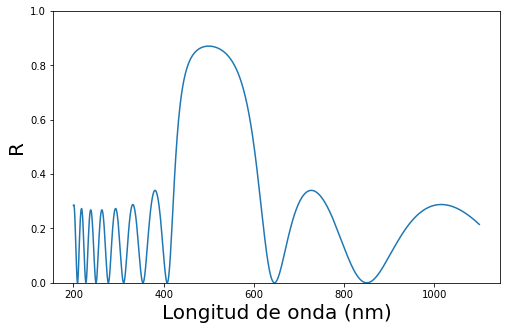

In [7]:
#graficamos la respuesta dada

plt.figure(figsize=(8,5))
plt.plot(lo,ro)

plt.xlabel("Longitud de onda (nm)", fontsize=20)
plt.ylabel("R", fontsize = 20)
plt.ylim(0.,1.)
plt.show()

In [8]:
#Si se desea simular utilizando un material con valores constantes descomentar las siguientes lineas de código 
#y comentar las anteriores

mat1 = pd.DataFrame({0 : lo, 1: [2.1]*len(lo), 2: [0.]*len(lo)})
mat2 = pd.DataFrame({0 : lo, 1: [1.5]*len(lo), 2: [0.]*len(lo)})

In [9]:
#Crearemos una PC con M=10 capas
M = 10
dd = 1 #ancho de paso
#Obtenemos la longitud de onda incial, para ello se compara la longitud de onda mínima de los tres materiales
lini = [mat1[0].min(), mat2[0].min(), lo.min()]
lini = max(lini)
#Obtenemos la longitud de onda final, para ello se compara la longitud de onda máxima de los tres materiales
lfin = [mat1[0].max(), mat2[0].max(), lo.max()]
lfin = min(lfin)
#Arreglo con longitudes de onda
#lini=735
#lfin=915
l = np.linspace(lini,lfin, int((lfin-lini)/dd) +1)

#Si se desea tomar el error para un intervalo particular descomentar las siguientes lineas y asignar valores
#lini=400   #long inicial nm
#lfin=1100  #long final nm
values=[]
for i in range(len(lo)):
    if lo[i]==lini:
        values.append(i)
    if lo[i]==lfin:
        values.append(i)

In [9]:
#Implementación del Algoritmo Genético
def Gen(ro, l, mat1, mat2, M,  ini, fin, espesor1=10, espesor2=500, pob=10, S=150, err0=5):
    #ro = array con valores de reflectancia que deseamos aproximar 
    #l = array con valores de las longitudes de onda
    #mat1 = array del primer material
    #mat2 = array del segundo material
    #M = número de capas del PC
    #ini, fin = intervalo de longitud de onda onde queremos calcular el error
    #espesor 1, espesor 2 = intervalo de espesores que queremos asignar de manera aleatoria
    #pob = población a utilizar para el algoritmo genético
    #S = número de iteraciones (generaciones)
    #err0 = error aceptable
    R = [] #reflectanica de las poblaciones
    D = [] #arreglo con los valores de los grosores de las poblaciones
    ErrorP = [] #error de los padres
    ErrorMin = [] #error mínimo de cada generación
    for i in range(pob): #generaremos la primera generación 
        r, d = PC(M, mat1, mat2, l, espesor1, espesor2)
        R.append(r)
        D.append(d)
        err = 0.
        for j in range(ini,fin): #(len(r)):
            err += np.abs(ro[j]-r[j])
        ErrorP.append(err)

    ErrorMin.append(min(ErrorP))
    h=0
    #for h in range(S):
    
    while ErrorMin[-1] > err0 and h<S:
        Do = D
        for i in range(len(D)): #por familia

            #dM = random.sample(Do,1) #PC(M, mat1, mat2) #Do[ErrorP.index(min(ErrorP))] 
            Sons = []
            dSons = []
            errorSons = []
            for j in range(pob): #por hijo
                dM = []
                for k in range(M):  #generamos una madre por hijo
                    dM.append(random.uniform(espesor1,espesor2))
                Daux1 = random.sample(Do[i], 5) #obtenemos 5 espesores aleatorios del padre
                Daux2 = random.sample(dM, 5) #obtenemos 5 espesores aleatorios de la madre
                Daux = Daux1 + Daux2 #los combinamos
                random.shuffle(Daux) #los acomodamos de manera aleatoria

                dSons.append(Daux) #guardamos los valores de ese hijo
            Daux = [] #liata auxiliar
            for j in Do[i]: #generamos una mutación: esta consiste en agarrar los valores del padre y sumar o restar 5nm
                if random.randint(0,1)==1: 
                    Daux.append(j - 5. )
                else:
                    Daux.append(j + 5. )
                
            primero = Do[i][0] #generamos un hijo que siempre herede el primer valor del padre
            dSons.append( [primero] + random.sample(Do[i],4) + random.sample(dM, 5) )
            dSons.append([primero]*M)
            
            randD = [] #hijo adoptado
            for j in range(M):  
                randD.append(random.uniform(espesor1,espesor2))

            dSons.append(randD)

            dMuta = [] #agregamos una mutación
            for k in Do[i]: #generamos un hijo con la suma de los valores del padre y una gaussiana
                dMuta.append( k * ( 1 + 0.01 * np.random.normal() ) )
            dSons.append(dMuta)

            dSons.append(Do[i]) #agregagamos los valores del padre a la lista de los hijos para comparar los errores de todos

            for j in range(len(dSons)-1): #calculamos los errores de los hijos
                rAux, dAux = PC(M, mat1, mat2, l, espesor1, espesor2, dSons[j]) #para ellos calculamos la refrectancia de cada uno
                err = 0.
                for k in range(ini,fin): #calculo del error
                    err += np.abs(ro[k]-rAux[k])
                errorSons.append(err) #almacenamos el valores de cada hijo en una lista
            errorSons.append(ErrorP[i]) #agregamos el error del padre a la lista
            
            #de la lista de espesores de los hijos buscamos aquel que tenga menor error
            D[i] = dSons[errorSons.index(min(errorSons))] #guardamos esos nuevos valores en la lista de padres
            ErrorP[i] = min(errorSons) #guardamos su error en la lista de padres

        h += 1 #contador de iteraciones (generaciones)
        ErrorMin.append(min(ErrorP)) #comparamos todos los nuevos padres y guardamos en de menor error
        print(h, min(ErrorP)) #imprimimos la generación y el nuevo padre de menor error
        print(D[ErrorP.index(min(ErrorP))]) #imprimimos los espesores del padre mejor adaptado
        RR, DD = PC(M, mat1, mat2, l, espesor1, espesor2, D[ErrorP.index(min(ErrorP))]) #calculamos la reflectancia del padre major adaptado
        #graficamos al padre y la respuesta deseada (ro)
        plt.figure(figsize=(8,5))
        plt.plot(l,ro)
        plt.plot(l,RR)

        plt.xlabel("Longitud de onda (nm)", fontsize=20)
        plt.ylabel("R", fontsize = 20)
        #plt.ylim(lini,lfin)
        plt.show()
        
        #guardamos los datos del error minimo de de cada generación en un txt
        file = open("2.1_1.5_Error.txt", "a+")
        file.write(str(h) + " " + str(min(ErrorP)) + "\n")
        file.close()
        #regresamos la lista de errores mínimos y la lista de espesores del padre más adaptado
    return ErrorMin, D[ErrorP.index(min(ErrorP))]

1 80.89539250776453
[74.52669099202504, 52.5693682521701, 70.2482636938288, 91.31928847652155, 63.333446114840065, 50.41091581383628, 68.05431338792218, 94.7708826000777, 68.88223851480825, 74.82272412290068]


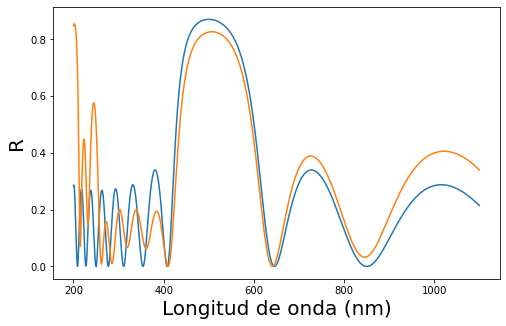

2 56.089562663185916
[68.30033378348438, 68.30033378348438, 68.30033378348438, 68.30033378348438, 68.30033378348438, 68.30033378348438, 68.30033378348438, 68.30033378348438, 68.30033378348438, 68.30033378348438]


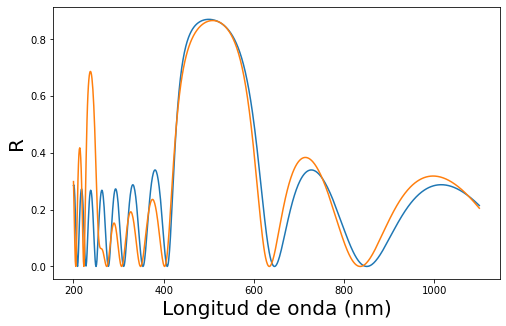

3 51.902348067913245
[67.85341326869494, 69.69203124341117, 68.47543550760696, 68.42114487517564, 69.75695404326375, 67.23037755462558, 67.58672893777455, 67.84186453110263, 67.82084066881387, 69.46607660935412]


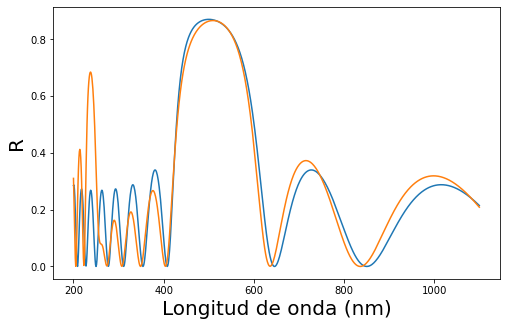

4 51.902348067913245
[67.85341326869494, 69.69203124341117, 68.47543550760696, 68.42114487517564, 69.75695404326375, 67.23037755462558, 67.58672893777455, 67.84186453110263, 67.82084066881387, 69.46607660935412]


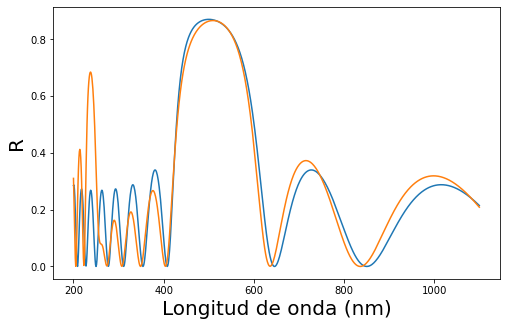

5 44.69343255859629
[67.44524681052788, 71.01904850836, 68.95946623365487, 68.34093404746915, 70.317281842519, 67.8395571144554, 67.8460178939788, 67.76539335428285, 66.3297353588791, 69.57480078493546]


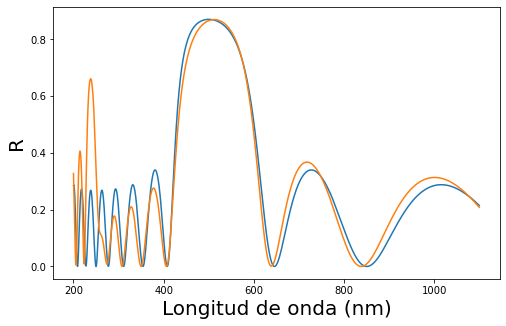

6 43.4500107273734
[67.38054958534151, 71.58898078008825, 67.78569899975966, 69.16366711549985, 71.18864598174932, 67.74673901625243, 67.59119866644839, 68.80779182907152, 66.30160852014524, 69.33691313110094]


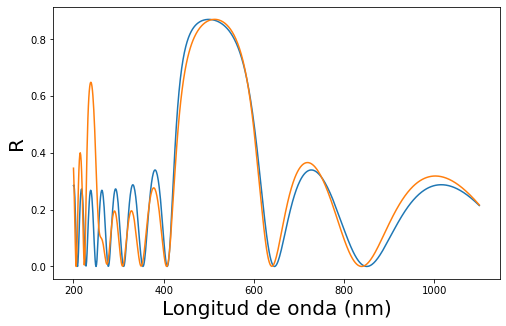

7 42.00242874451015
[66.86918668929304, 71.99256771894636, 67.44147276138531, 68.98116691706626, 71.69445786721971, 67.54076563230883, 67.57627969883151, 70.09525201542836, 66.41275289212703, 69.72662911846795]


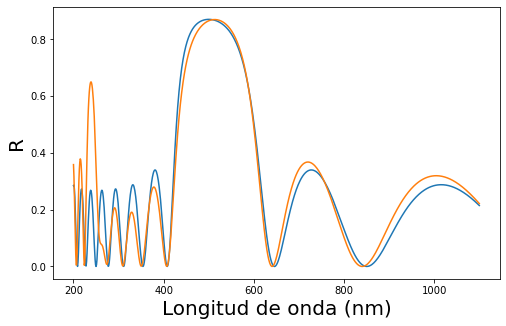

8 39.18927328893694
[66.57922868790207, 73.42190810429635, 67.86680407392983, 70.46400190597406, 71.71011020842582, 67.13235842644771, 67.30658281849274, 69.05933748300438, 66.88839323946041, 69.67079330475858]


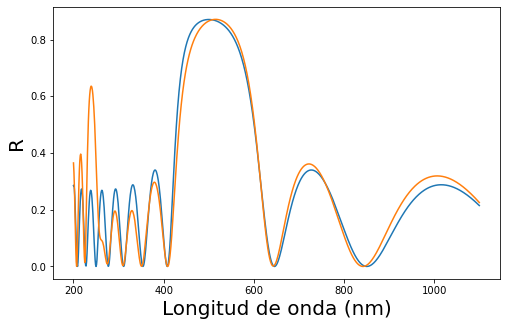

9 39.18927328893694
[66.57922868790207, 73.42190810429635, 67.86680407392983, 70.46400190597406, 71.71011020842582, 67.13235842644771, 67.30658281849274, 69.05933748300438, 66.88839323946041, 69.67079330475858]


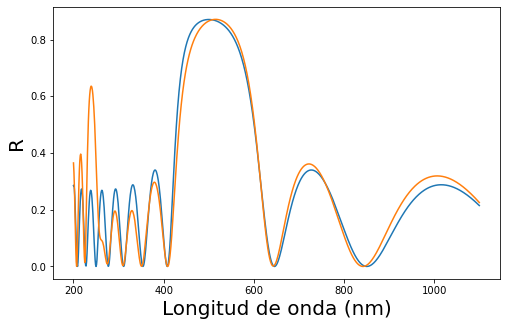

10 38.92928709768331
[66.71364220614655, 73.64490359753844, 67.79927100893585, 70.02381621152357, 71.89117568526046, 68.45327314168675, 66.35683718292204, 69.99017729179286, 66.20322049226526, 69.40764473257953]


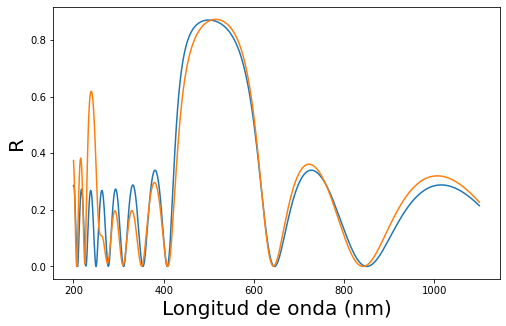

11 38.48926213169658
[65.52339043258803, 74.21792528736876, 67.8915490521721, 69.75987542253591, 71.50440712231122, 68.47921245063547, 66.46117906501213, 70.12625694773327, 66.47686807343315, 69.33604007699633]


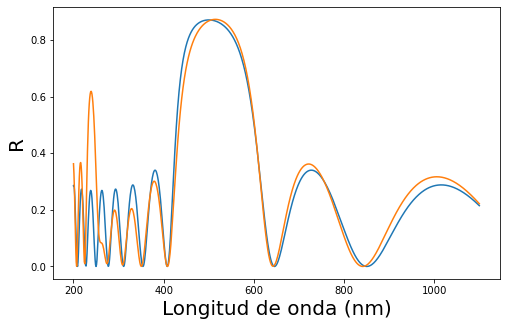

12 37.24667934397421
[65.3668914095967, 75.04762725625253, 67.40857133941145, 70.47940817282284, 71.99523505592656, 68.99633356411927, 68.15791669071642, 69.9492622333882, 66.82486075514215, 69.43034282202598]


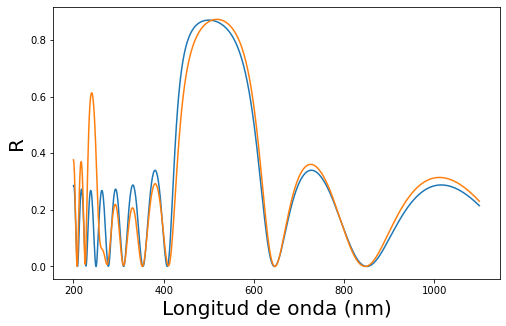

13 37.24667934397421
[65.3668914095967, 75.04762725625253, 67.40857133941145, 70.47940817282284, 71.99523505592656, 68.99633356411927, 68.15791669071642, 69.9492622333882, 66.82486075514215, 69.43034282202598]


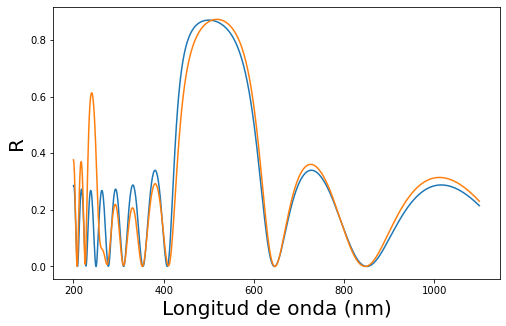

14 37.24667934397421
[65.3668914095967, 75.04762725625253, 67.40857133941145, 70.47940817282284, 71.99523505592656, 68.99633356411927, 68.15791669071642, 69.9492622333882, 66.82486075514215, 69.43034282202598]


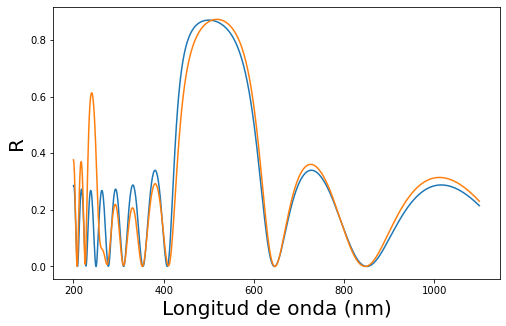

15 34.42516666795662
[63.21643048874129, 76.39616221046842, 67.31821784395366, 70.54154932775656, 71.90929519160318, 68.57614121726333, 67.06168013042229, 70.43052289997878, 66.77409545984732, 70.11252098342763]


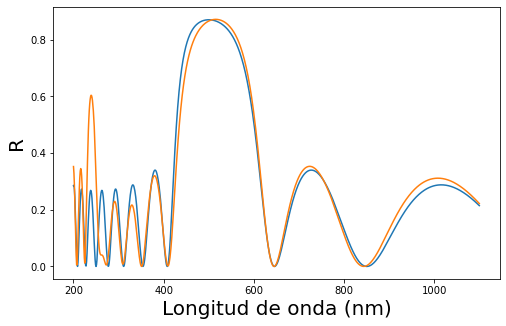

16 33.78122878989945
[63.20511043592888, 77.44863354688701, 66.95121775381394, 70.6718668662156, 72.26631777357302, 68.28691271766506, 66.96986890516308, 70.14741165767931, 66.55123506943637, 70.75375801757164]


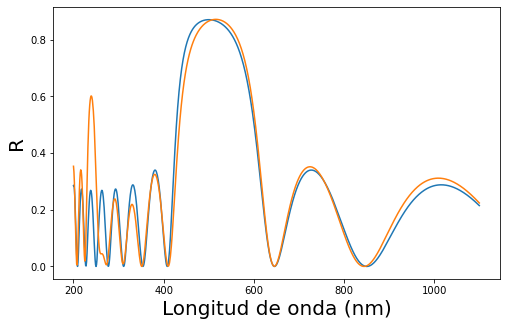

17 33.78122878989945
[63.20511043592888, 77.44863354688701, 66.95121775381394, 70.6718668662156, 72.26631777357302, 68.28691271766506, 66.96986890516308, 70.14741165767931, 66.55123506943637, 70.75375801757164]


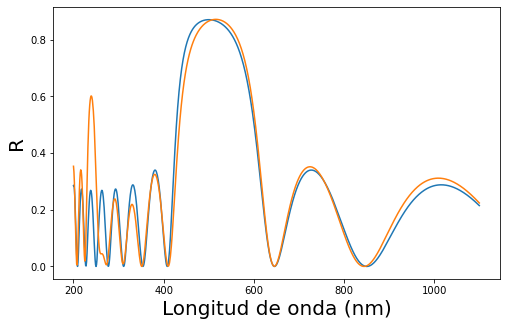

18 33.78122878989945
[63.20511043592888, 77.44863354688701, 66.95121775381394, 70.6718668662156, 72.26631777357302, 68.28691271766506, 66.96986890516308, 70.14741165767931, 66.55123506943637, 70.75375801757164]


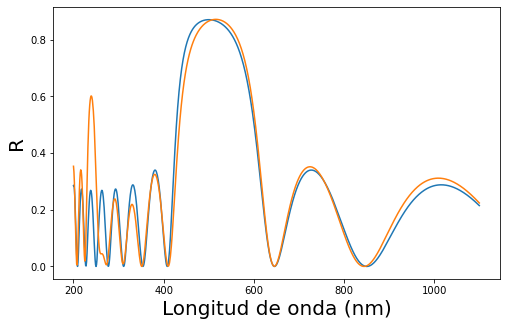

19 33.530435290267405
[63.330072322214534, 77.00720427092432, 67.44601312664695, 70.48733232065688, 71.6584567982858, 67.38804929917922, 67.35140163523793, 70.67904546825226, 65.61532296987491, 70.80301053187287]


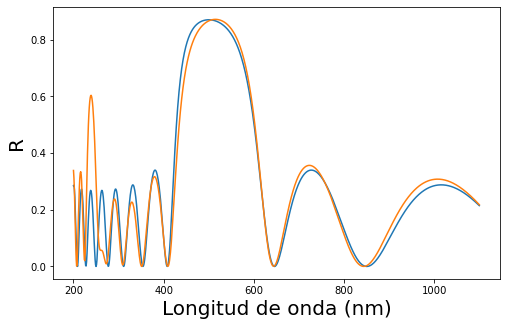

20 31.728518465222866
[63.50296972583387, 77.31037384034425, 67.44677091994454, 71.17860343975708, 71.06995675134938, 68.60477385584767, 67.29667245027392, 70.29646108530767, 65.71236685640187, 71.55127950644814]


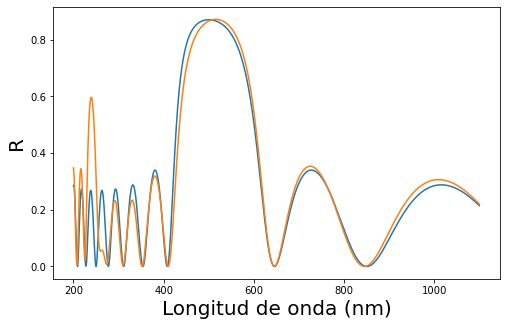

21 31.728518465222866
[63.50296972583387, 77.31037384034425, 67.44677091994454, 71.17860343975708, 71.06995675134938, 68.60477385584767, 67.29667245027392, 70.29646108530767, 65.71236685640187, 71.55127950644814]


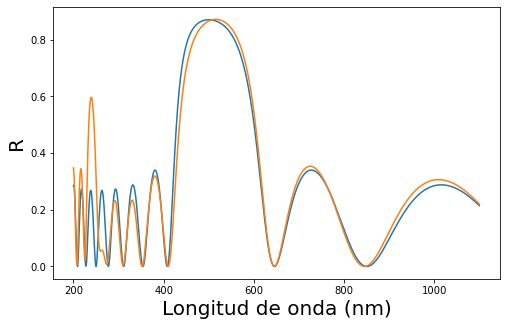

22 31.728518465222866
[63.50296972583387, 77.31037384034425, 67.44677091994454, 71.17860343975708, 71.06995675134938, 68.60477385584767, 67.29667245027392, 70.29646108530767, 65.71236685640187, 71.55127950644814]


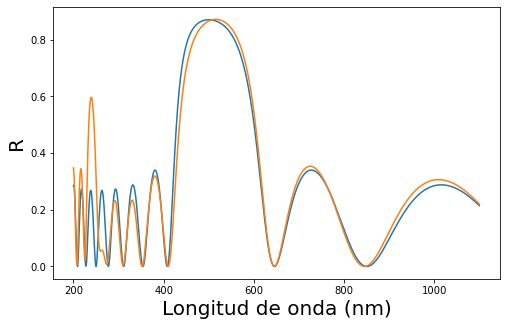

23 31.728518465222866
[63.50296972583387, 77.31037384034425, 67.44677091994454, 71.17860343975708, 71.06995675134938, 68.60477385584767, 67.29667245027392, 70.29646108530767, 65.71236685640187, 71.55127950644814]


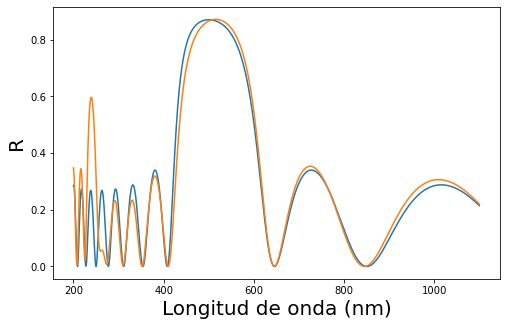

24 31.728518465222866
[63.50296972583387, 77.31037384034425, 67.44677091994454, 71.17860343975708, 71.06995675134938, 68.60477385584767, 67.29667245027392, 70.29646108530767, 65.71236685640187, 71.55127950644814]


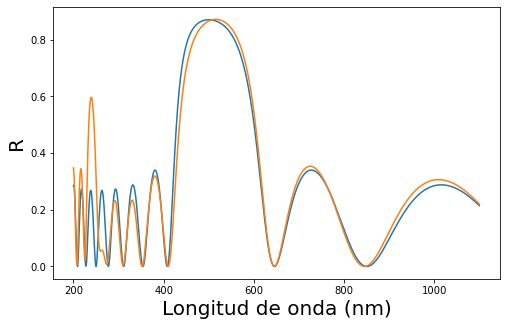

25 31.728518465222866
[63.50296972583387, 77.31037384034425, 67.44677091994454, 71.17860343975708, 71.06995675134938, 68.60477385584767, 67.29667245027392, 70.29646108530767, 65.71236685640187, 71.55127950644814]


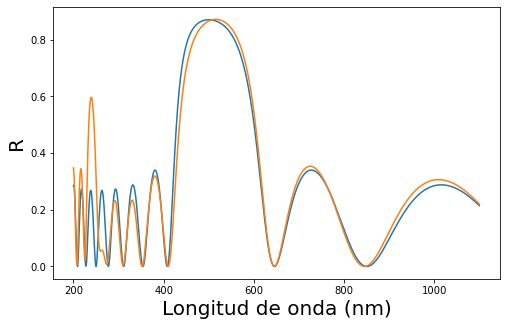

26 31.66065864528525
[63.830473490459795, 77.7747692736576, 68.39497261371957, 70.56693276547058, 70.9909918293677, 69.0843104306557, 66.79586770927203, 69.90064212533743, 65.92052880409868, 71.9646533937452]


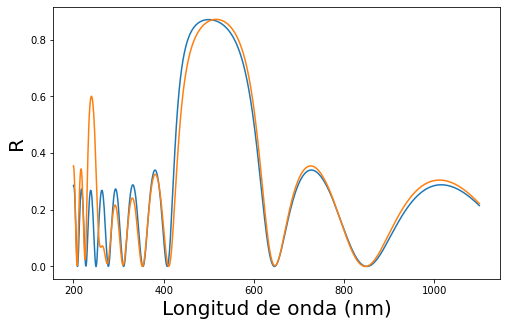

27 31.66065864528525
[63.830473490459795, 77.7747692736576, 68.39497261371957, 70.56693276547058, 70.9909918293677, 69.0843104306557, 66.79586770927203, 69.90064212533743, 65.92052880409868, 71.9646533937452]


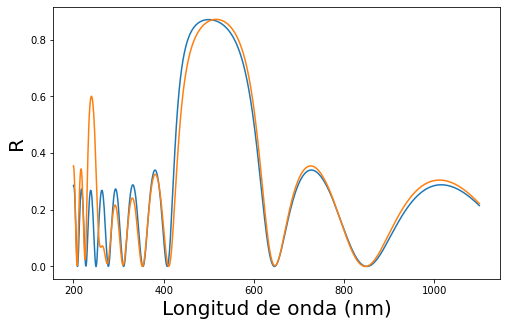

28 31.66065864528525
[63.830473490459795, 77.7747692736576, 68.39497261371957, 70.56693276547058, 70.9909918293677, 69.0843104306557, 66.79586770927203, 69.90064212533743, 65.92052880409868, 71.9646533937452]


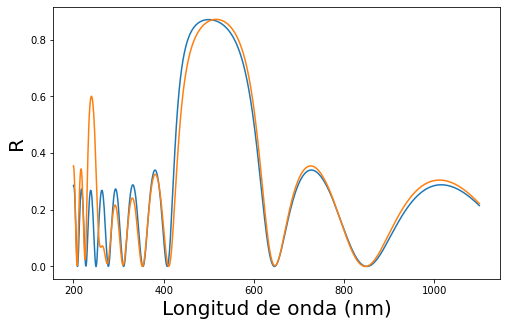

29 30.297358202867024
[63.491117408062586, 78.01479009409645, 68.77974556341783, 70.62163747174023, 70.44553235990783, 69.01929627248042, 66.43645494394853, 71.82324265737667, 65.62345482057131, 72.98006721671713]


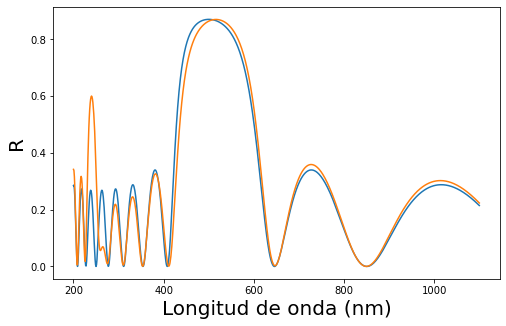

30 29.150362198137383
[63.95268543000834, 78.3019444065019, 68.08816400686989, 69.7144746671982, 70.10005771255086, 68.38508884815577, 67.40834572351172, 70.78920436522242, 65.30579153637446, 73.16981604447369]


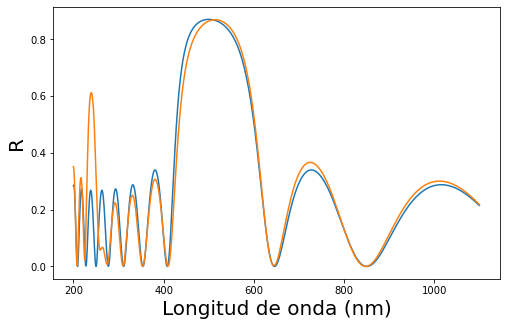

31 29.150362198137383
[63.95268543000834, 78.3019444065019, 68.08816400686989, 69.7144746671982, 70.10005771255086, 68.38508884815577, 67.40834572351172, 70.78920436522242, 65.30579153637446, 73.16981604447369]


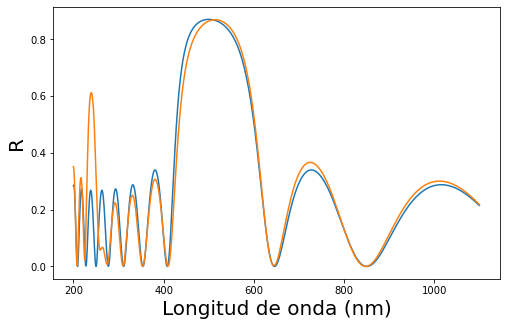

32 29.150362198137383
[63.95268543000834, 78.3019444065019, 68.08816400686989, 69.7144746671982, 70.10005771255086, 68.38508884815577, 67.40834572351172, 70.78920436522242, 65.30579153637446, 73.16981604447369]


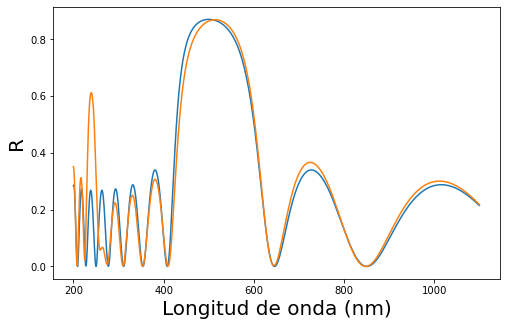

33 27.372173078613407
[62.856232090909835, 77.44484484822867, 67.9807485118009, 70.31858447437887, 69.30773779068201, 68.94552235208674, 68.18986435937533, 70.37166406438732, 65.8542625523301, 73.61630586399492]


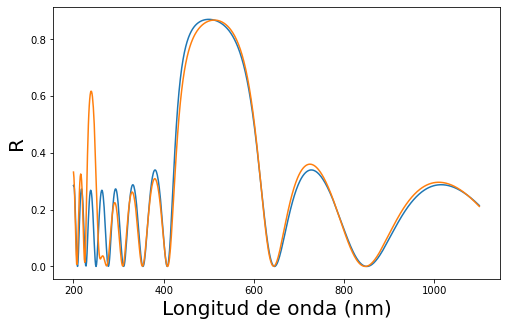

34 27.372173078613407
[62.856232090909835, 77.44484484822867, 67.9807485118009, 70.31858447437887, 69.30773779068201, 68.94552235208674, 68.18986435937533, 70.37166406438732, 65.8542625523301, 73.61630586399492]


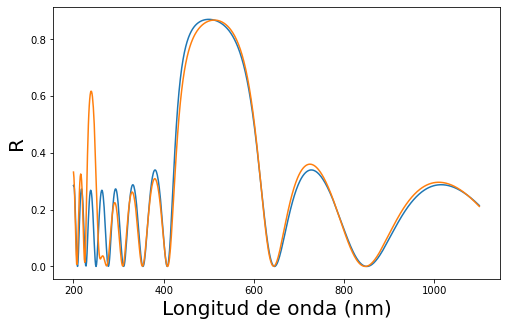

35 27.372173078613407
[62.856232090909835, 77.44484484822867, 67.9807485118009, 70.31858447437887, 69.30773779068201, 68.94552235208674, 68.18986435937533, 70.37166406438732, 65.8542625523301, 73.61630586399492]


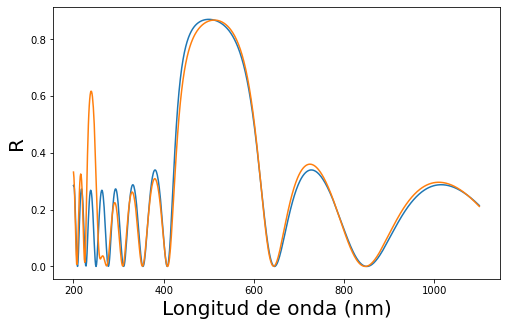

36 27.372173078613407
[62.856232090909835, 77.44484484822867, 67.9807485118009, 70.31858447437887, 69.30773779068201, 68.94552235208674, 68.18986435937533, 70.37166406438732, 65.8542625523301, 73.61630586399492]


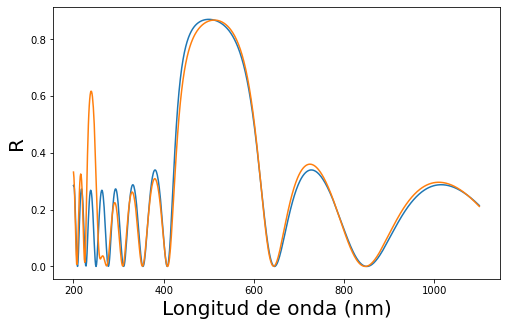

37 27.372173078613407
[62.856232090909835, 77.44484484822867, 67.9807485118009, 70.31858447437887, 69.30773779068201, 68.94552235208674, 68.18986435937533, 70.37166406438732, 65.8542625523301, 73.61630586399492]


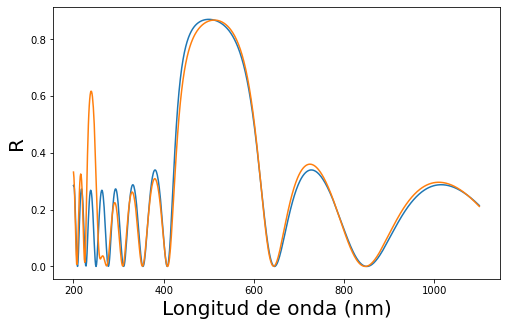

38 27.372173078613407
[62.856232090909835, 77.44484484822867, 67.9807485118009, 70.31858447437887, 69.30773779068201, 68.94552235208674, 68.18986435937533, 70.37166406438732, 65.8542625523301, 73.61630586399492]


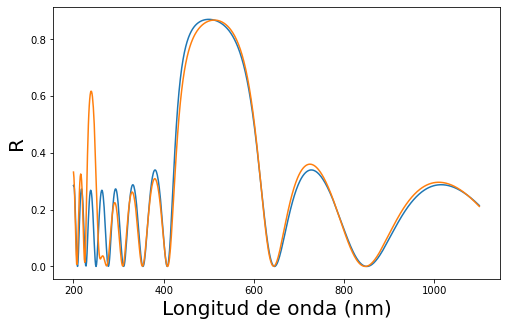

39 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


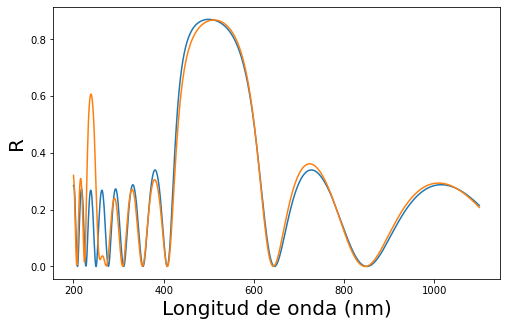

40 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


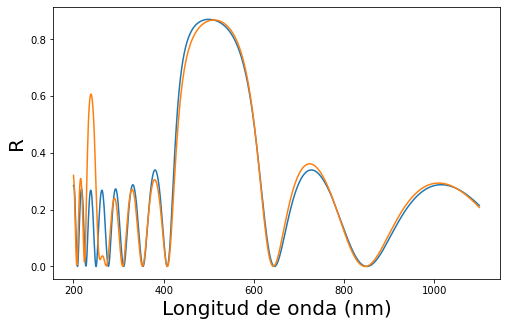

41 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


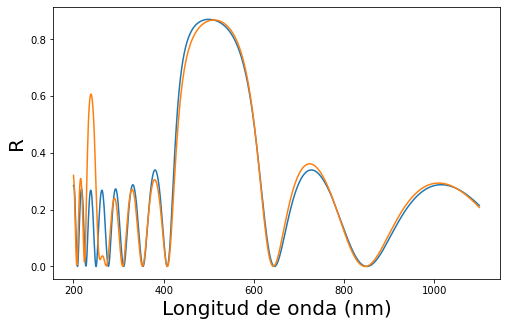

42 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


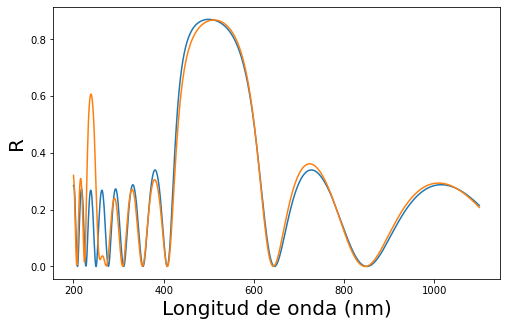

43 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


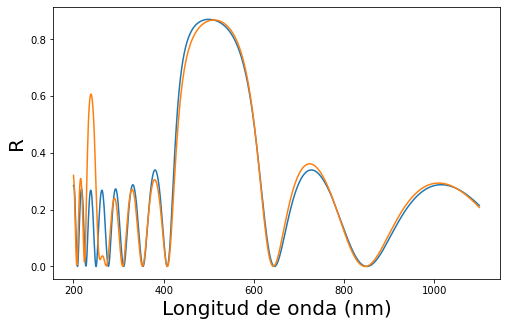

44 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


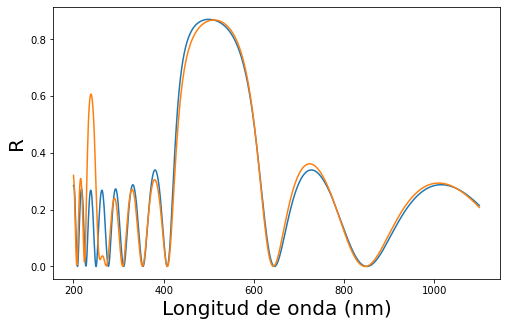

45 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


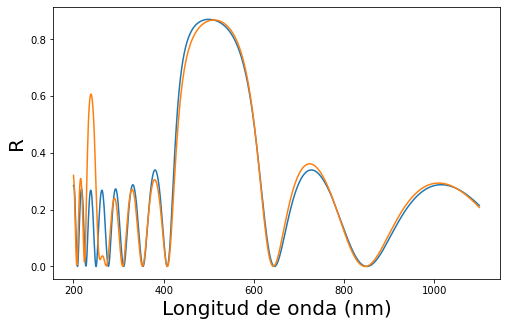

46 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


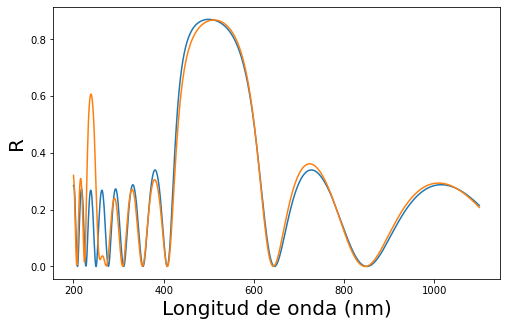

47 27.014540250249173
[62.41925997293297, 77.84321317317587, 67.5849805765691, 70.52232675819316, 68.9878365940891, 68.80564632686692, 68.41580689037849, 71.23843052403893, 64.86702991627685, 74.02075298890894]


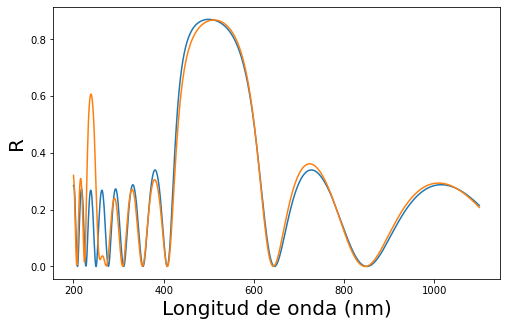

48 25.96888245840127
[61.638781692491335, 78.712423837114, 67.89525503643894, 70.8324599561172, 68.8112413797105, 68.51221749245668, 67.68772010094612, 71.37656532604139, 64.48244125004678, 75.17128706728724]


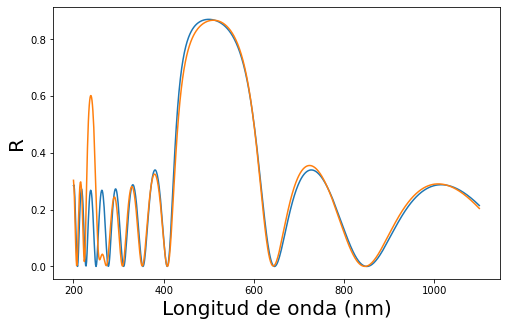

49 25.96888245840127
[61.638781692491335, 78.712423837114, 67.89525503643894, 70.8324599561172, 68.8112413797105, 68.51221749245668, 67.68772010094612, 71.37656532604139, 64.48244125004678, 75.17128706728724]


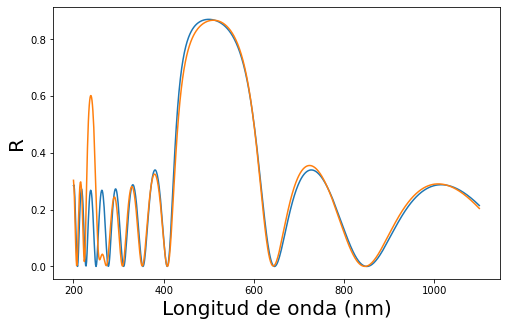

50 25.04057757623765
[61.323399825094604, 80.01574349500466, 67.3787781472729, 70.33760407958331, 69.90209604260646, 68.79446823469455, 68.32967528626789, 71.18193771774716, 63.64051484081656, 74.90429288088052]


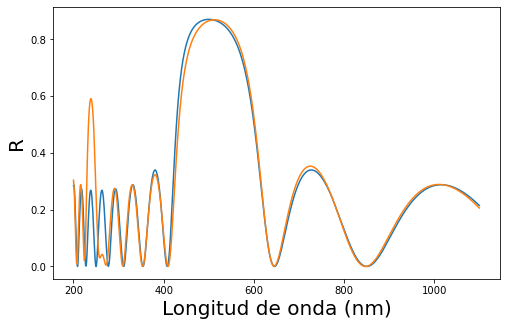

51 25.04057757623765
[61.323399825094604, 80.01574349500466, 67.3787781472729, 70.33760407958331, 69.90209604260646, 68.79446823469455, 68.32967528626789, 71.18193771774716, 63.64051484081656, 74.90429288088052]


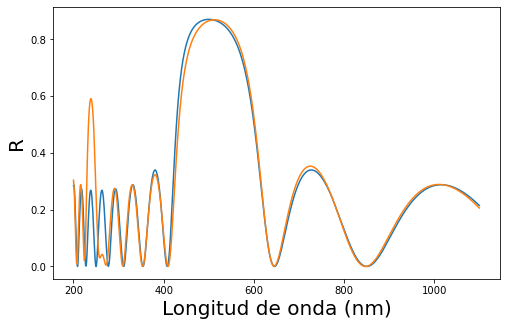

52 25.04057757623765
[61.323399825094604, 80.01574349500466, 67.3787781472729, 70.33760407958331, 69.90209604260646, 68.79446823469455, 68.32967528626789, 71.18193771774716, 63.64051484081656, 74.90429288088052]


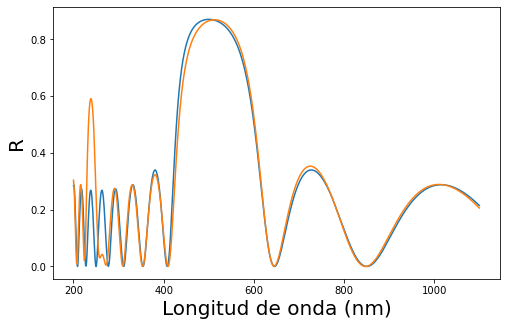

53 25.04057757623765
[61.323399825094604, 80.01574349500466, 67.3787781472729, 70.33760407958331, 69.90209604260646, 68.79446823469455, 68.32967528626789, 71.18193771774716, 63.64051484081656, 74.90429288088052]


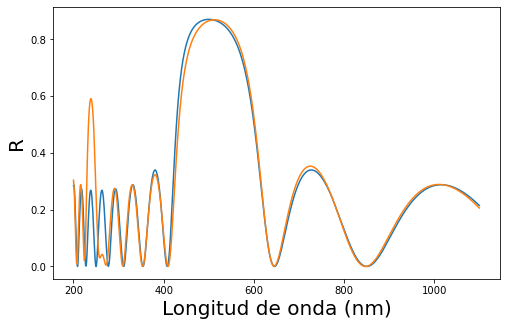

54 25.04057757623765
[61.323399825094604, 80.01574349500466, 67.3787781472729, 70.33760407958331, 69.90209604260646, 68.79446823469455, 68.32967528626789, 71.18193771774716, 63.64051484081656, 74.90429288088052]


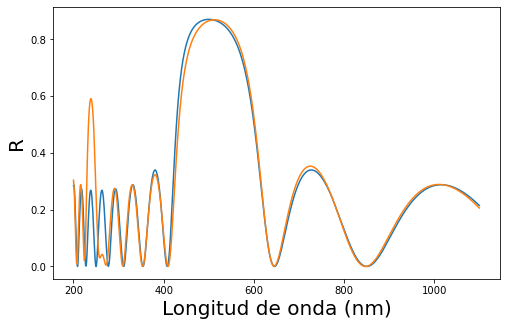

55 25.04057757623765
[61.323399825094604, 80.01574349500466, 67.3787781472729, 70.33760407958331, 69.90209604260646, 68.79446823469455, 68.32967528626789, 71.18193771774716, 63.64051484081656, 74.90429288088052]


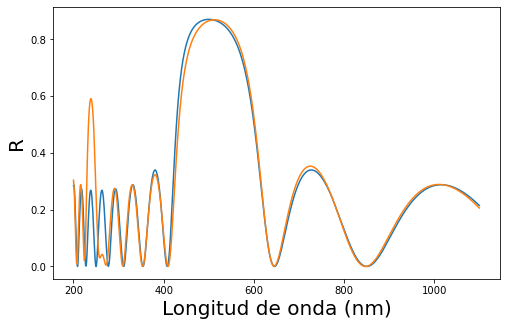

56 24.961021333408176
[60.63647731406206, 79.7354081259311, 66.54077274348364, 70.86846371126903, 70.0174059483919, 68.96769769016619, 67.66959691590917, 71.81278717365518, 64.87875404320502, 74.87185479492562]


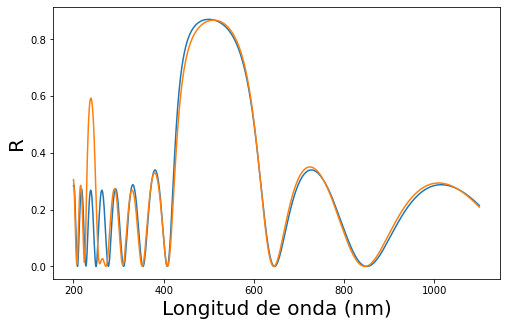

57 24.961021333408176
[60.63647731406206, 79.7354081259311, 66.54077274348364, 70.86846371126903, 70.0174059483919, 68.96769769016619, 67.66959691590917, 71.81278717365518, 64.87875404320502, 74.87185479492562]


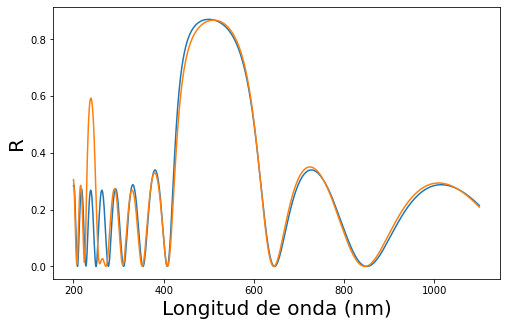

58 23.770557460503085
[61.29825917601989, 78.89016310436092, 67.69721767537132, 69.21436666149417, 70.97520390966437, 69.20165279900323, 67.41836484081944, 70.85240122462639, 65.22315494296967, 76.4036508471825]


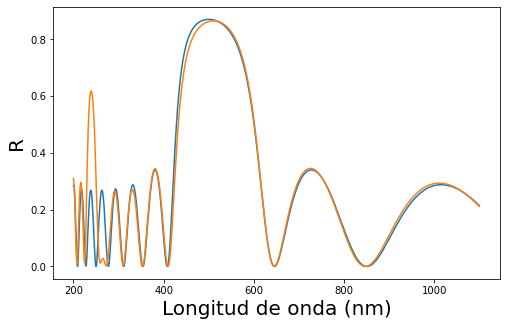

59 23.635486802446923
[61.25088654182017, 79.30437000983551, 66.1946009930793, 69.96033817183444, 71.10356984623368, 69.19365394160793, 67.43182988507124, 70.86401236514865, 66.02460176981911, 76.47257760545155]


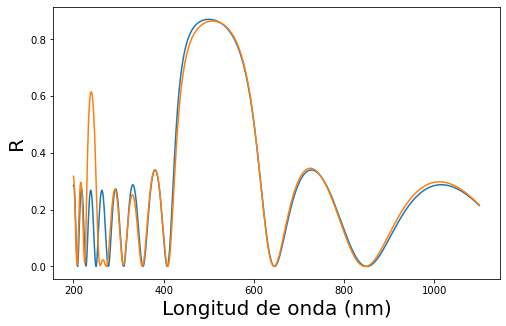

60 22.50359250599667
[60.34854046779221, 77.92299162800657, 66.59361996369887, 70.13457635034374, 70.68220212727466, 70.28258771811998, 67.39501316665104, 71.86010787515234, 66.10964317176119, 77.17785163624949]


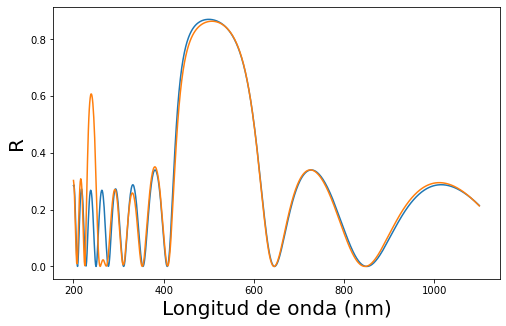

61 22.50359250599667
[60.34854046779221, 77.92299162800657, 66.59361996369887, 70.13457635034374, 70.68220212727466, 70.28258771811998, 67.39501316665104, 71.86010787515234, 66.10964317176119, 77.17785163624949]


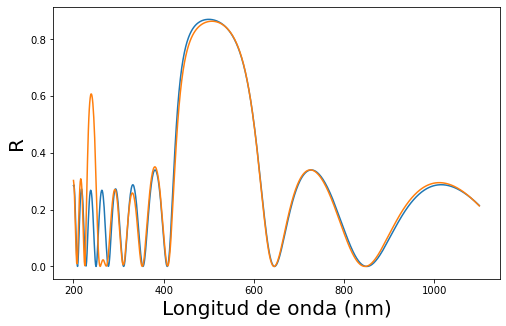

62 22.50359250599667
[60.34854046779221, 77.92299162800657, 66.59361996369887, 70.13457635034374, 70.68220212727466, 70.28258771811998, 67.39501316665104, 71.86010787515234, 66.10964317176119, 77.17785163624949]


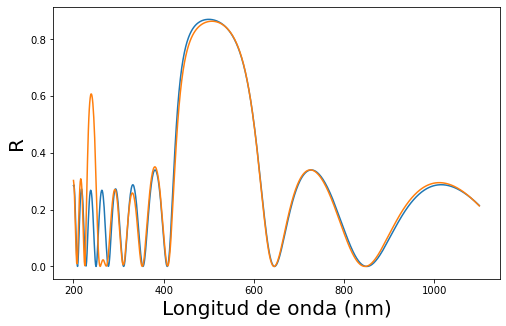

63 22.50359250599667
[60.34854046779221, 77.92299162800657, 66.59361996369887, 70.13457635034374, 70.68220212727466, 70.28258771811998, 67.39501316665104, 71.86010787515234, 66.10964317176119, 77.17785163624949]


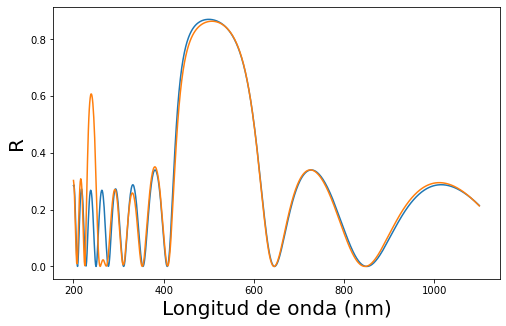

64 22.50359250599667
[60.34854046779221, 77.92299162800657, 66.59361996369887, 70.13457635034374, 70.68220212727466, 70.28258771811998, 67.39501316665104, 71.86010787515234, 66.10964317176119, 77.17785163624949]


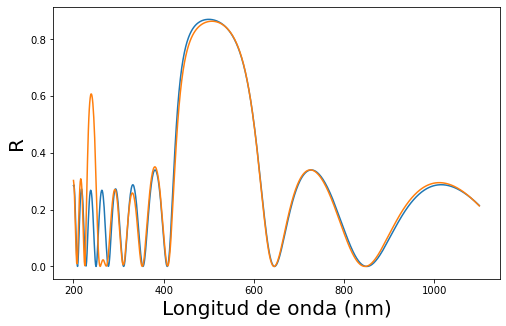

65 22.50359250599667
[60.34854046779221, 77.92299162800657, 66.59361996369887, 70.13457635034374, 70.68220212727466, 70.28258771811998, 67.39501316665104, 71.86010787515234, 66.10964317176119, 77.17785163624949]


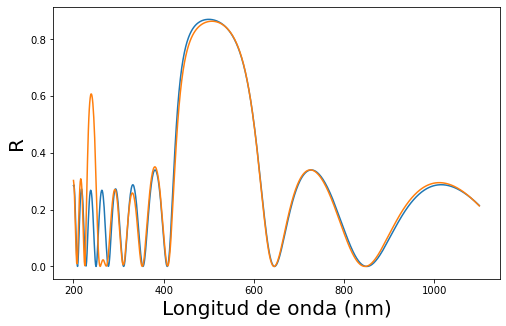

66 20.434375542539126
[59.98012377605426, 78.13290122196888, 66.94725960034252, 69.83715926831579, 70.56524937241517, 70.82455916375555, 68.13537280370436, 71.7977192391209, 64.97376467856655, 79.10434019503454]


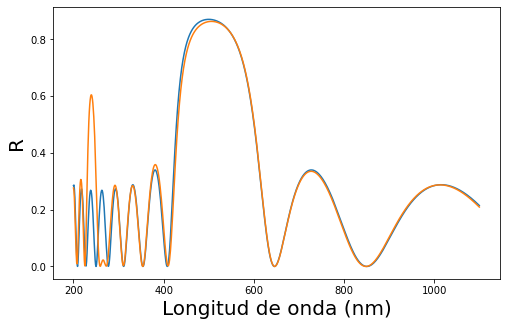

67 20.434375542539126
[59.98012377605426, 78.13290122196888, 66.94725960034252, 69.83715926831579, 70.56524937241517, 70.82455916375555, 68.13537280370436, 71.7977192391209, 64.97376467856655, 79.10434019503454]


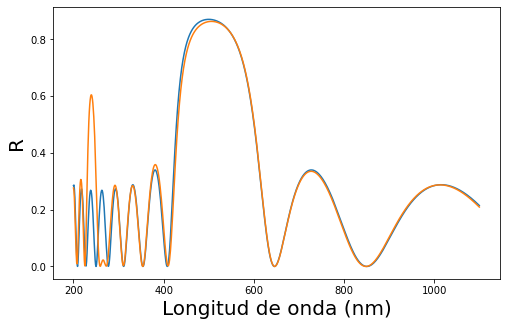

68 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


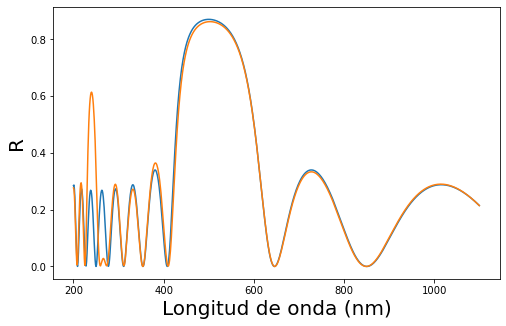

69 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


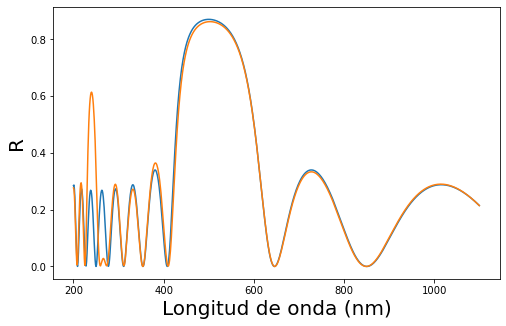

70 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


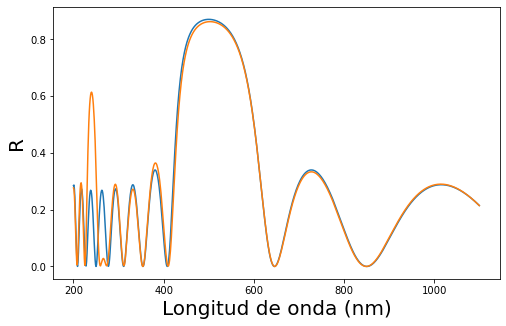

71 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


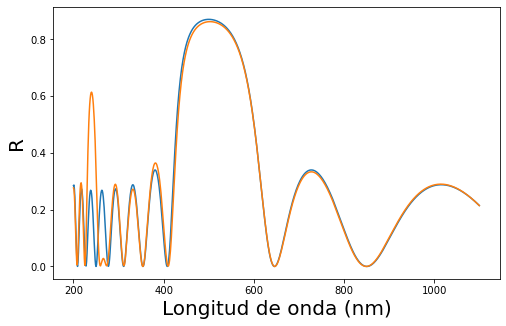

72 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


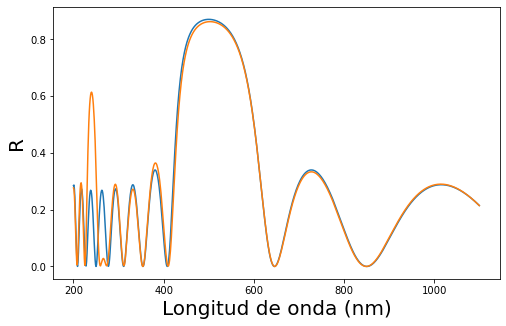

73 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


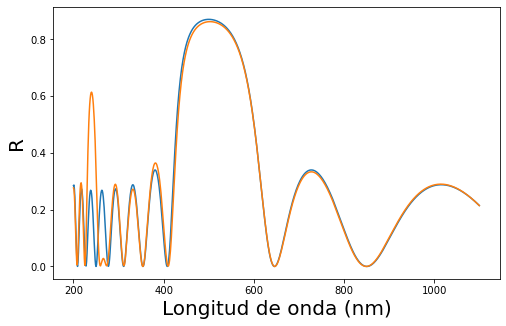

74 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


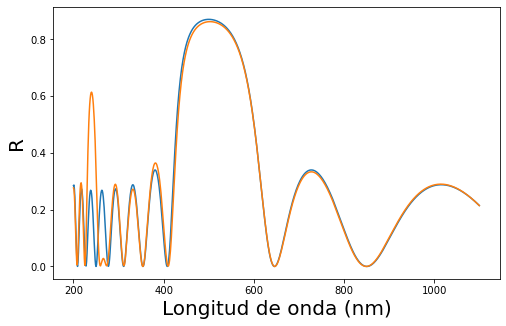

75 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


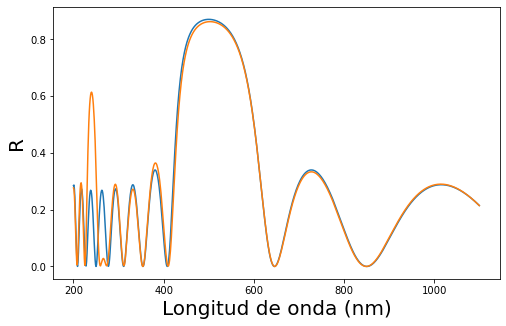

76 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


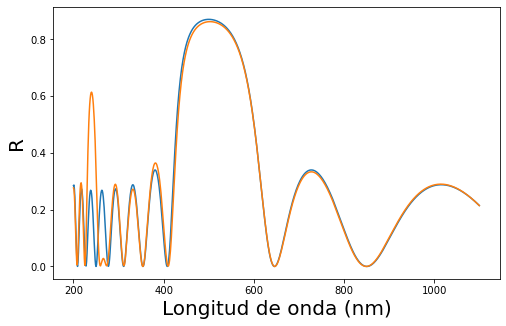

77 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


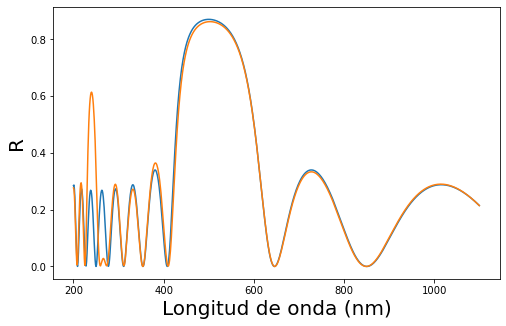

78 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


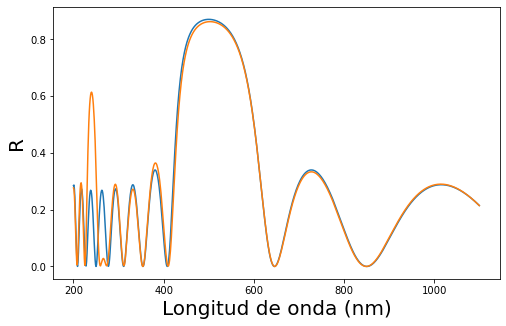

79 20.034184986069516
[60.42077883204072, 78.36063893289968, 66.27786143414768, 69.87325378831795, 71.05399548880929, 70.21068584663787, 68.03202953317653, 71.69946287733785, 65.26071250215323, 80.85626802465534]


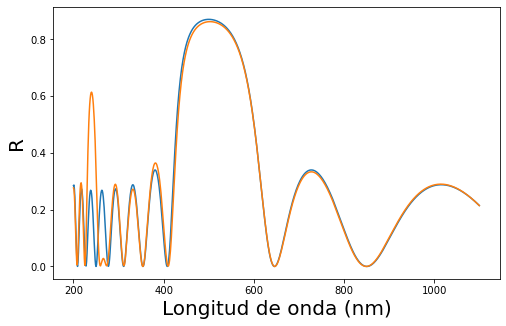

80 20.003958062591764
[61.02215334893617, 79.32457329422067, 66.52921165297376, 69.65792454990608, 70.35448707589212, 69.86895444643868, 67.31990693435561, 70.63131947983953, 66.43674619877986, 79.7188074638661]


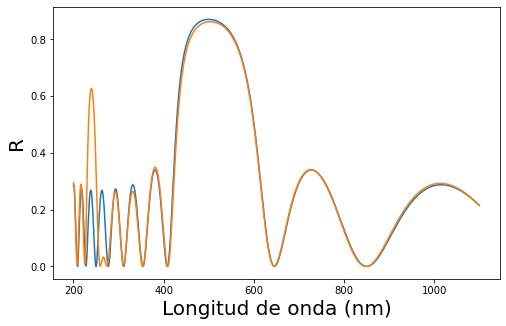

81 20.003958062591764
[61.02215334893617, 79.32457329422067, 66.52921165297376, 69.65792454990608, 70.35448707589212, 69.86895444643868, 67.31990693435561, 70.63131947983953, 66.43674619877986, 79.7188074638661]


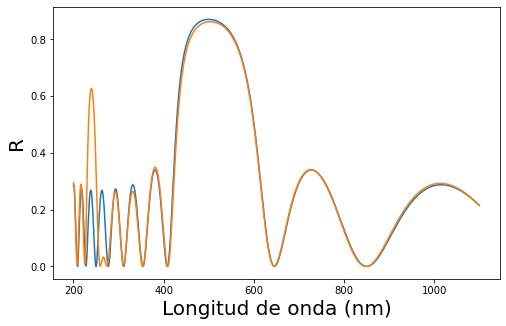

82 20.003958062591764
[61.02215334893617, 79.32457329422067, 66.52921165297376, 69.65792454990608, 70.35448707589212, 69.86895444643868, 67.31990693435561, 70.63131947983953, 66.43674619877986, 79.7188074638661]


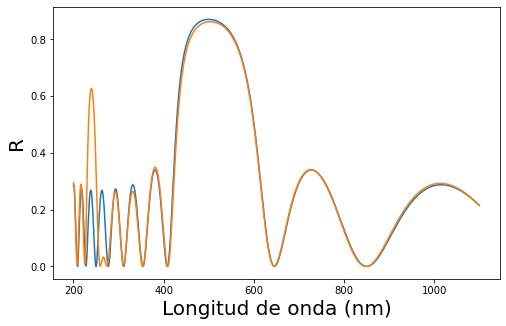

83 20.003958062591764
[61.02215334893617, 79.32457329422067, 66.52921165297376, 69.65792454990608, 70.35448707589212, 69.86895444643868, 67.31990693435561, 70.63131947983953, 66.43674619877986, 79.7188074638661]


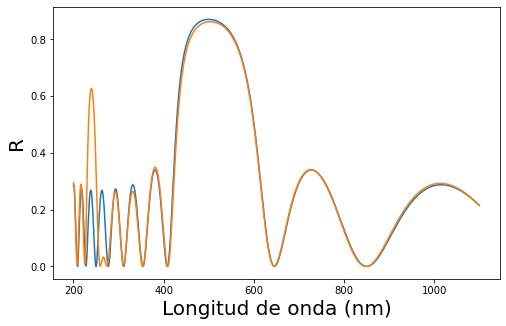

84 20.003958062591764
[61.02215334893617, 79.32457329422067, 66.52921165297376, 69.65792454990608, 70.35448707589212, 69.86895444643868, 67.31990693435561, 70.63131947983953, 66.43674619877986, 79.7188074638661]


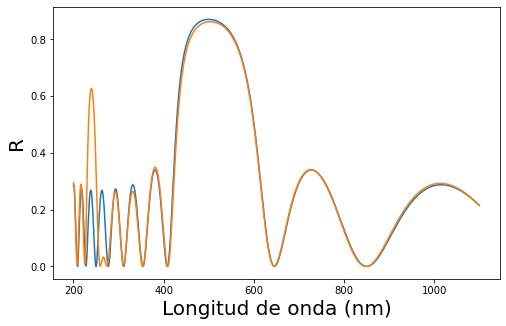

85 20.003958062591764
[61.02215334893617, 79.32457329422067, 66.52921165297376, 69.65792454990608, 70.35448707589212, 69.86895444643868, 67.31990693435561, 70.63131947983953, 66.43674619877986, 79.7188074638661]


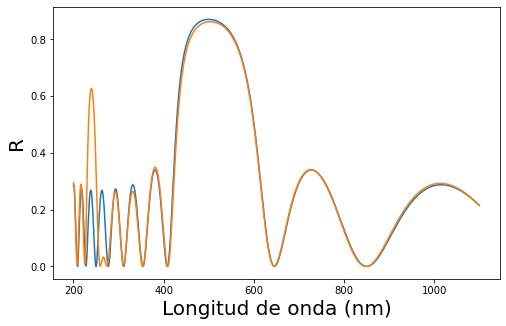

86 20.003958062591764
[61.02215334893617, 79.32457329422067, 66.52921165297376, 69.65792454990608, 70.35448707589212, 69.86895444643868, 67.31990693435561, 70.63131947983953, 66.43674619877986, 79.7188074638661]


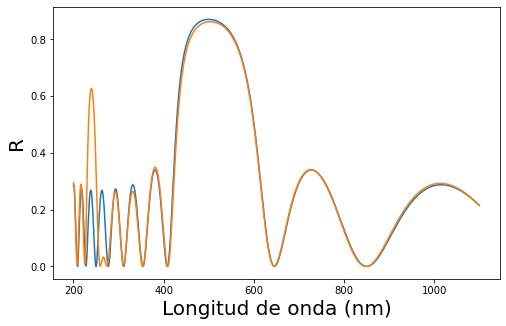

87 19.865952278295545
[60.4303872462369, 80.33208222599848, 66.14028752615084, 70.2394329155458, 69.12133439361803, 68.26953069436165, 68.21315327268364, 71.37675128699597, 66.28307799390296, 80.93646036642673]


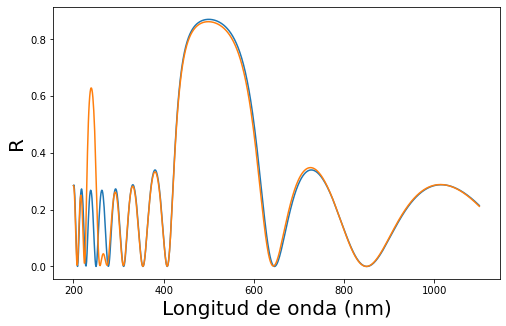

88 19.865952278295545
[60.4303872462369, 80.33208222599848, 66.14028752615084, 70.2394329155458, 69.12133439361803, 68.26953069436165, 68.21315327268364, 71.37675128699597, 66.28307799390296, 80.93646036642673]


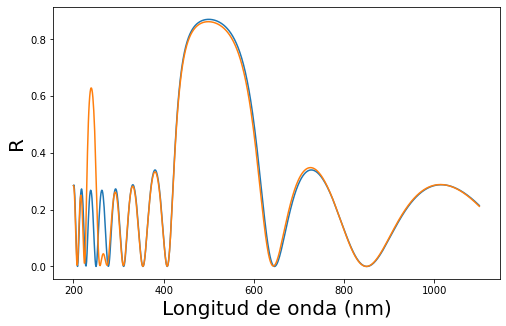

89 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


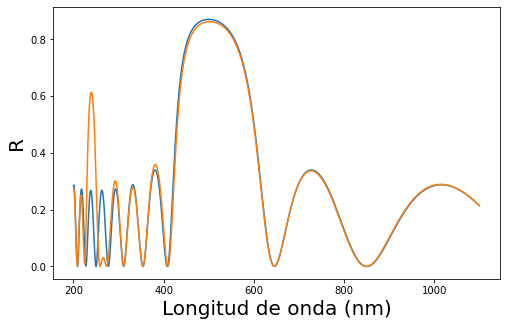

90 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


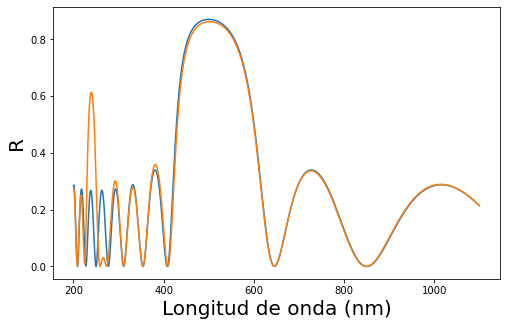

91 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


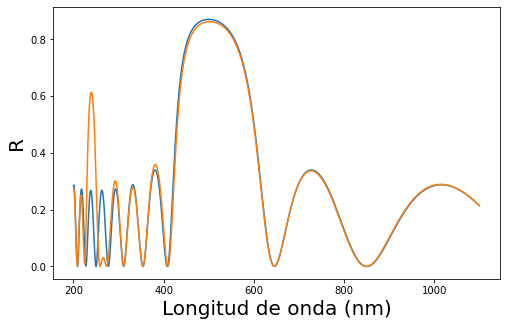

92 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


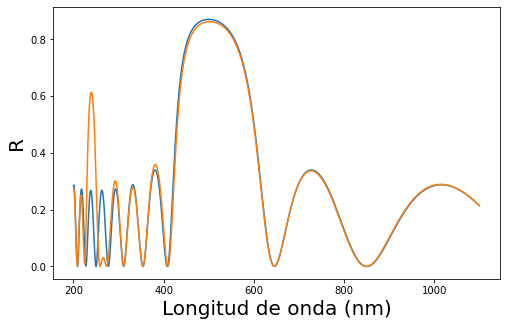

93 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


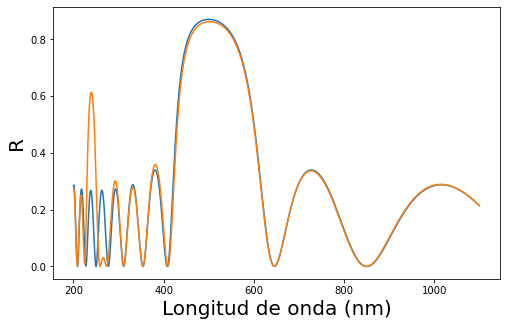

94 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


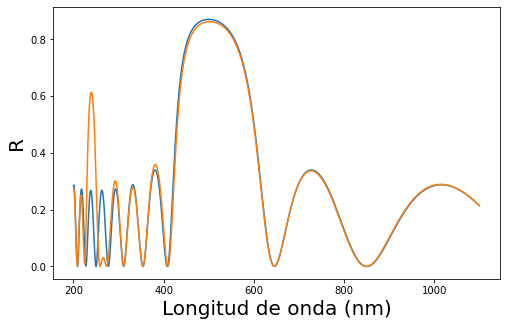

95 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


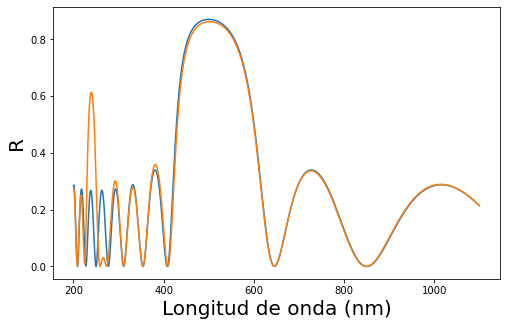

96 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


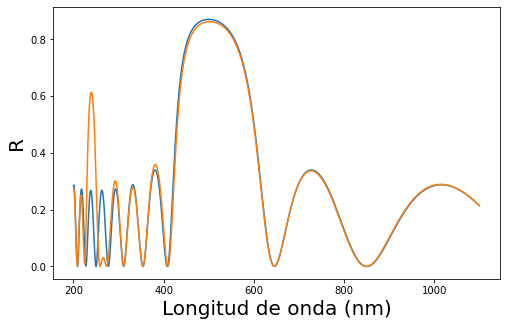

97 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


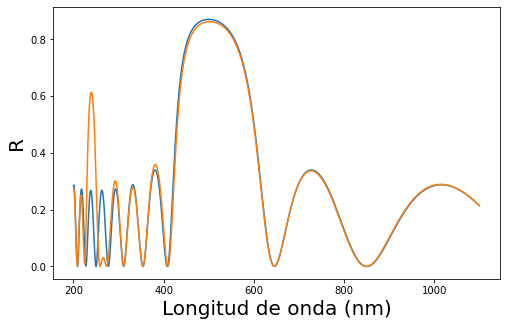

98 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


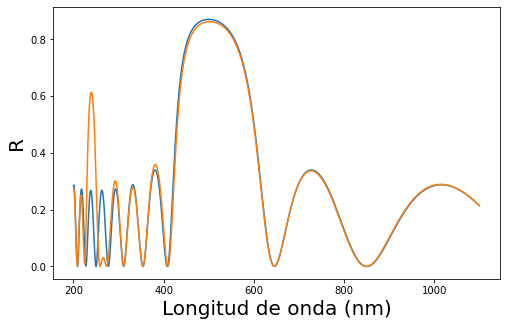

99 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


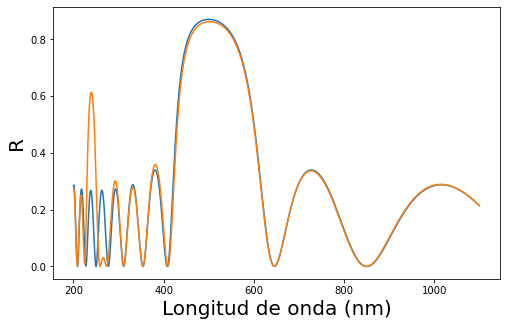

100 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


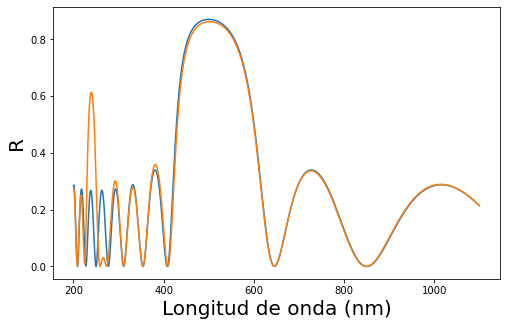

101 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


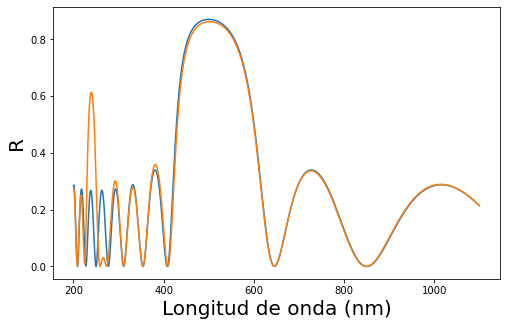

102 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


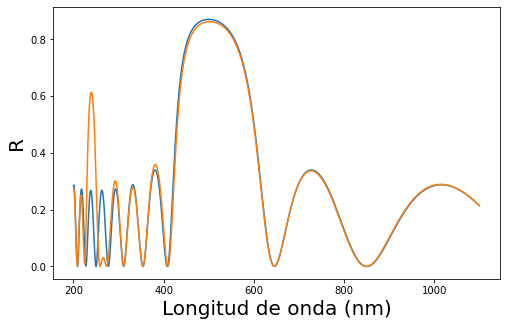

103 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


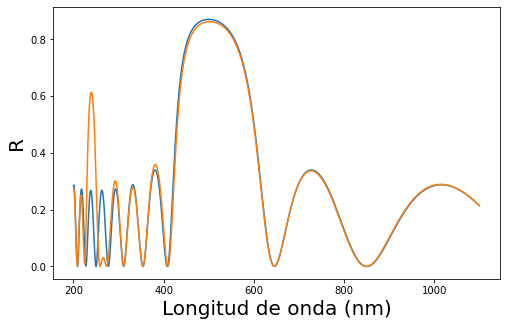

104 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


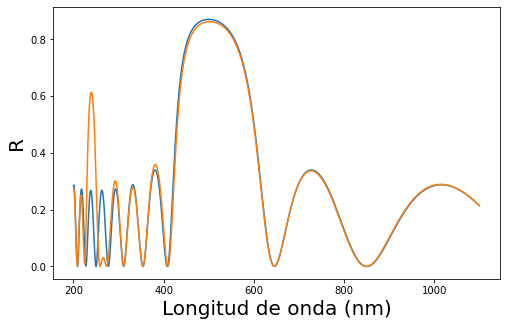

105 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


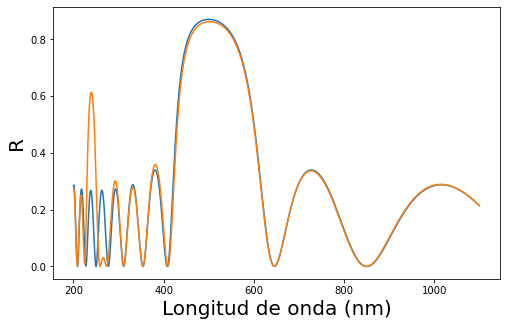

106 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


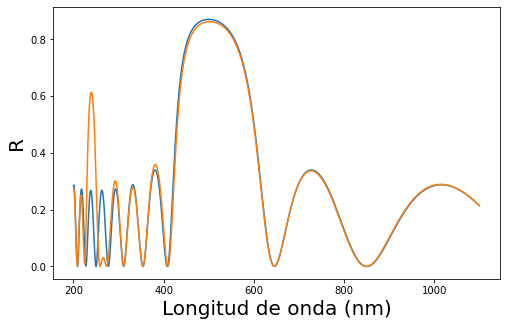

107 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


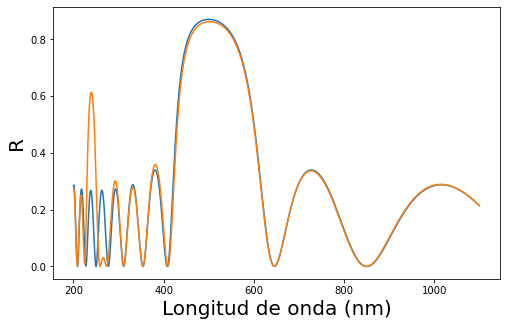

108 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


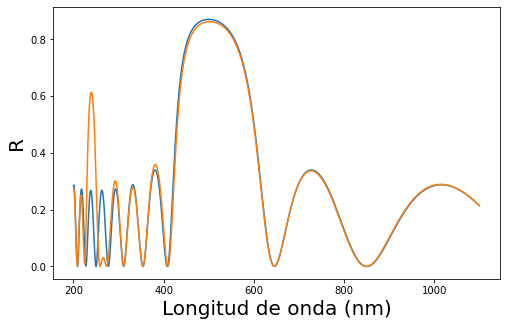

109 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


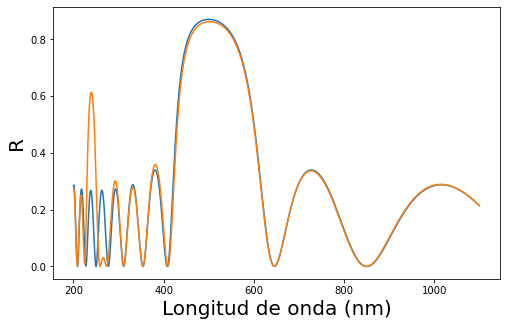

110 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


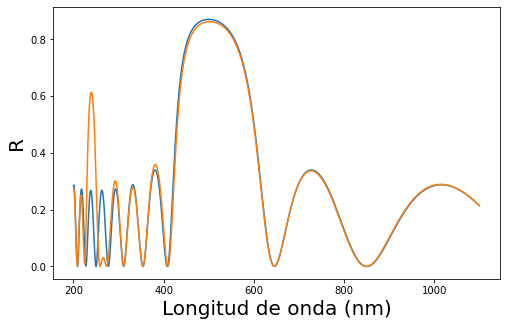

111 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


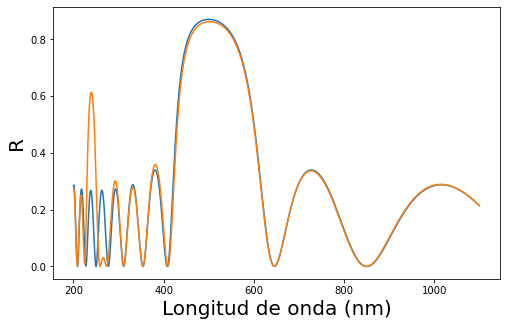

112 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


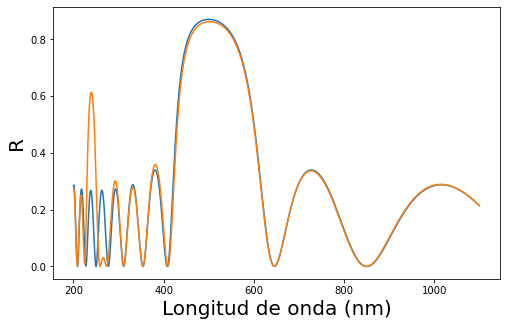

113 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


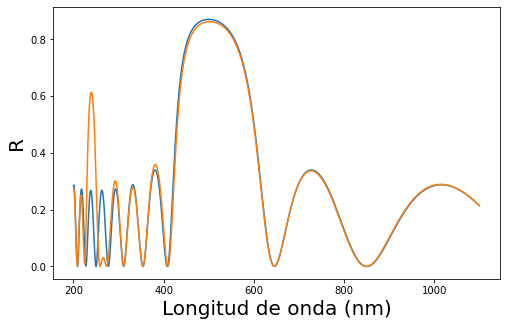

114 19.499613746046926
[60.28074361696055, 80.19704468259471, 65.84530726076255, 70.28797399057945, 70.84269301397613, 68.48242418886902, 67.89815661912981, 72.17845343533415, 64.5343229865223, 81.45606235763844]


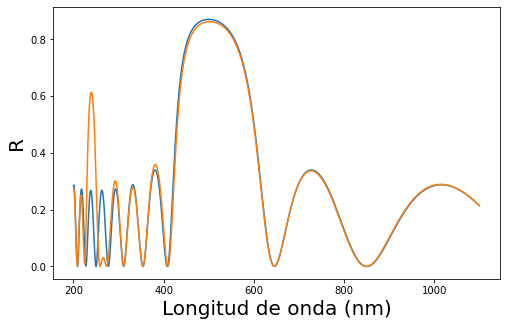

115 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


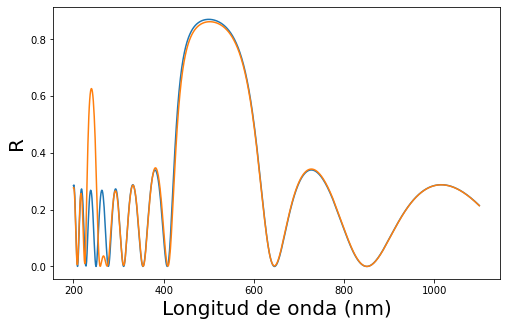

116 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


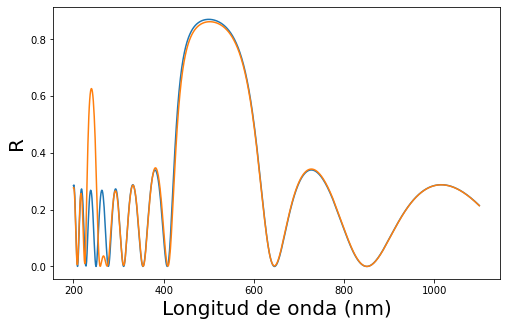

117 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


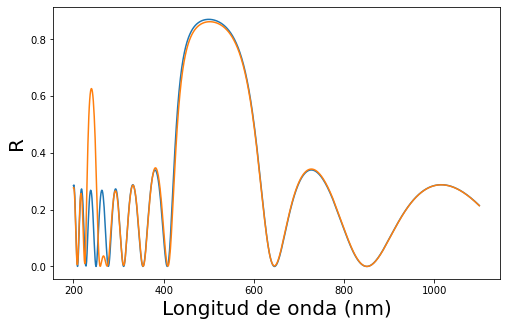

118 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


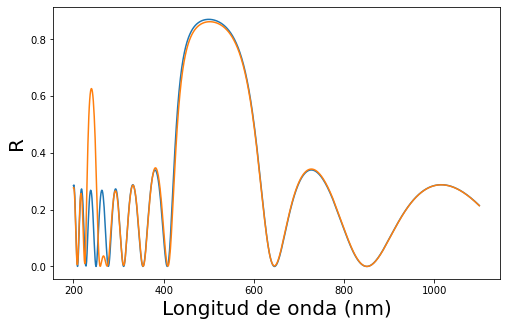

119 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


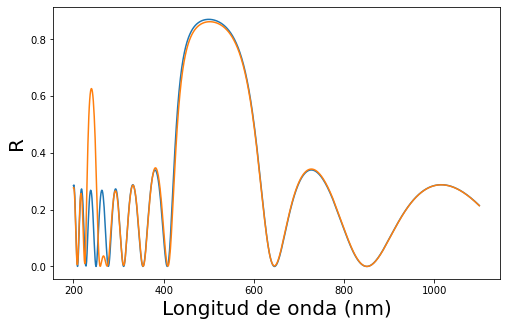

120 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


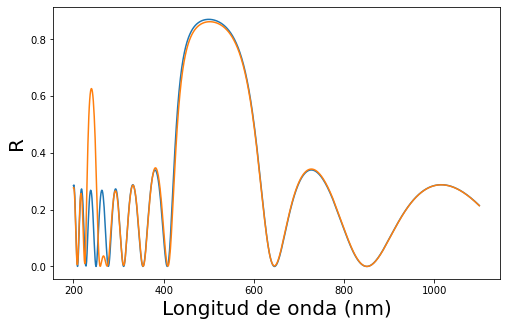

121 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


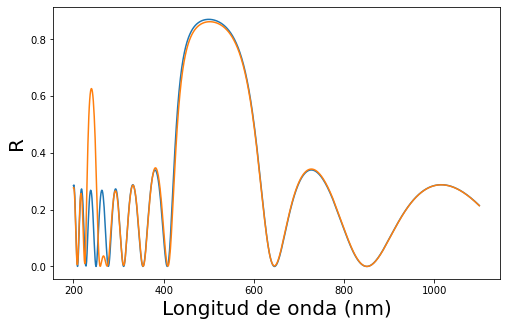

122 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


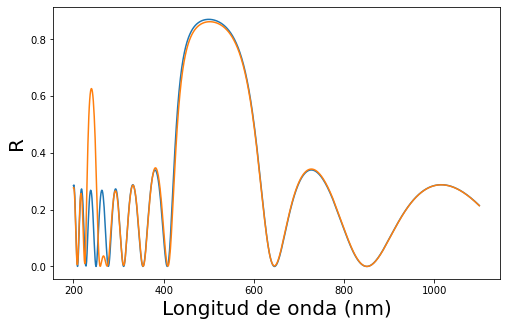

123 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


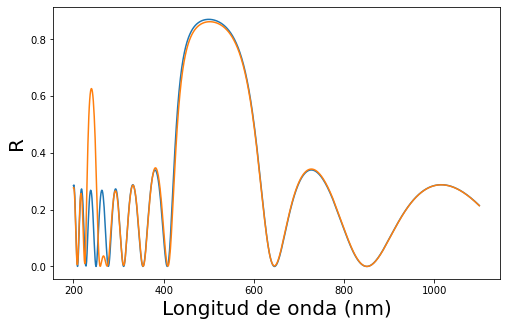

124 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


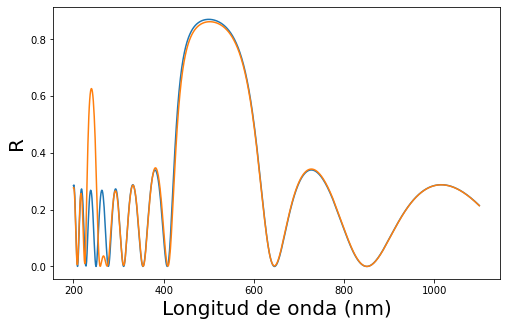

125 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


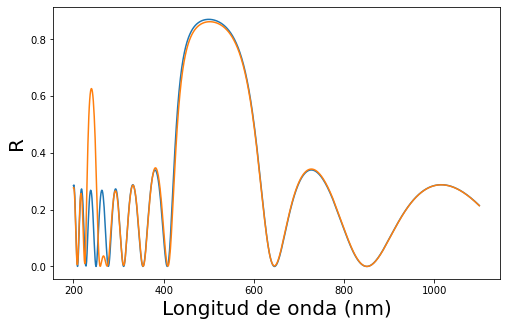

126 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


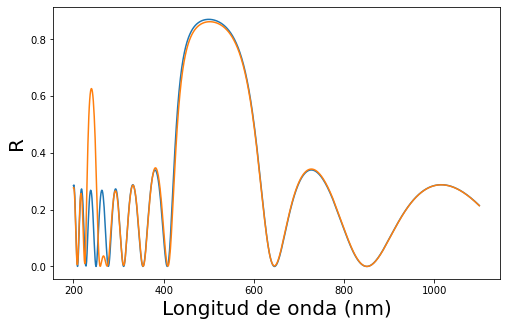

127 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


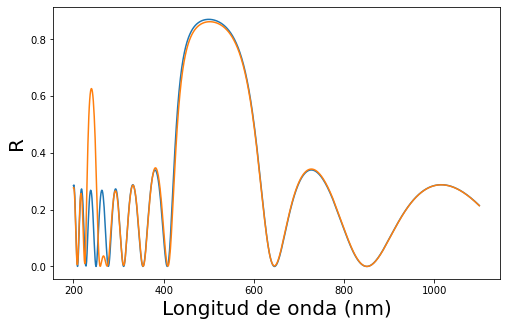

128 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


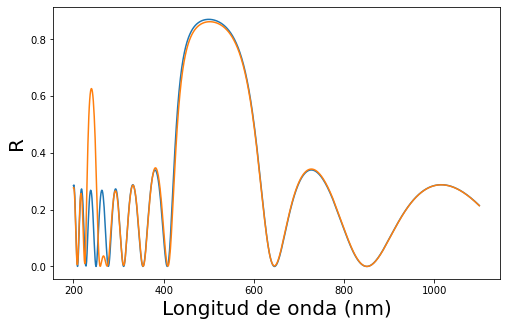

129 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


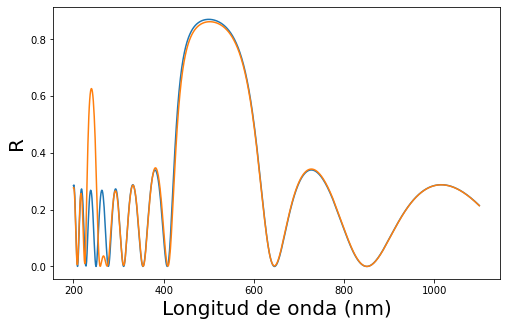

130 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


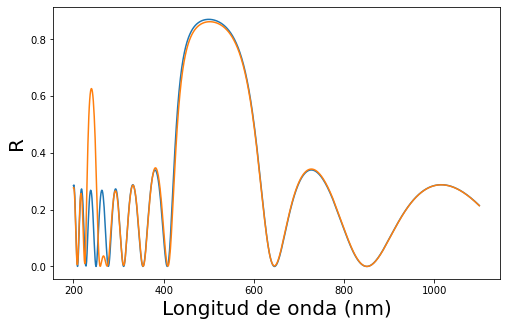

131 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


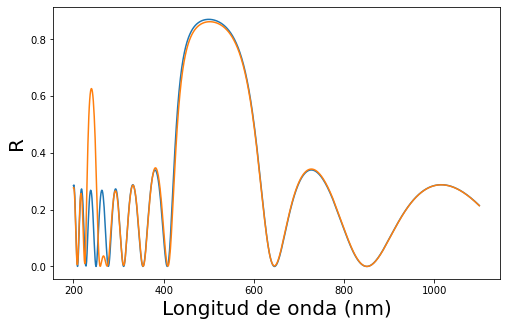

132 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


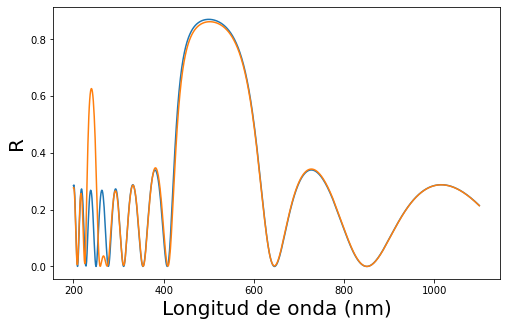

133 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


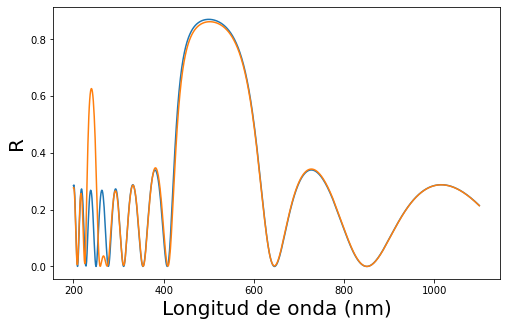

134 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


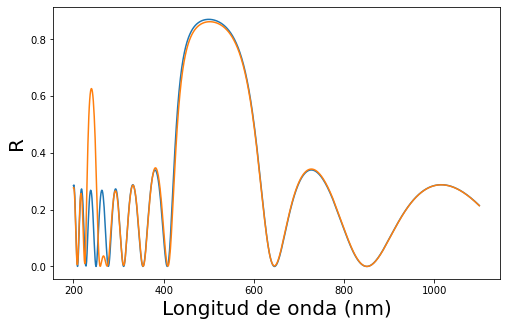

135 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


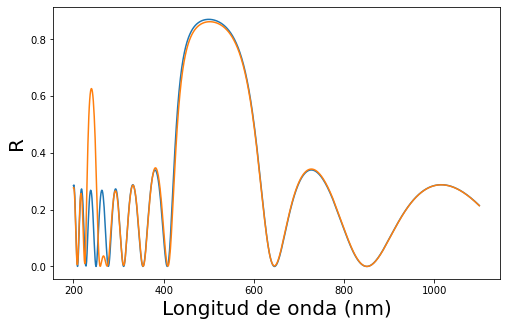

136 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


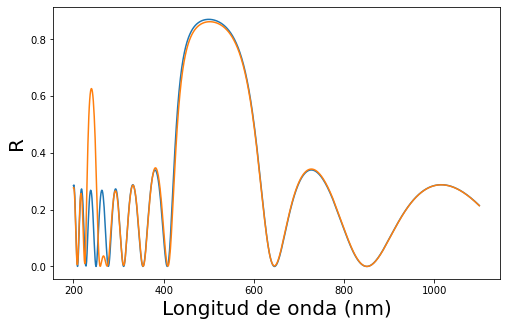

137 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


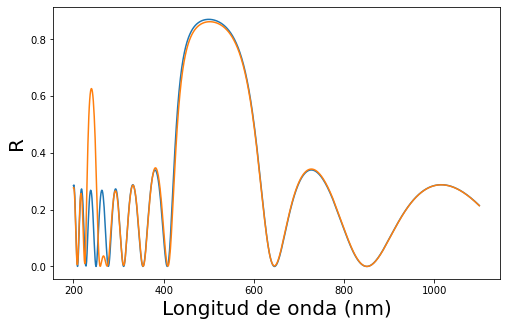

138 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


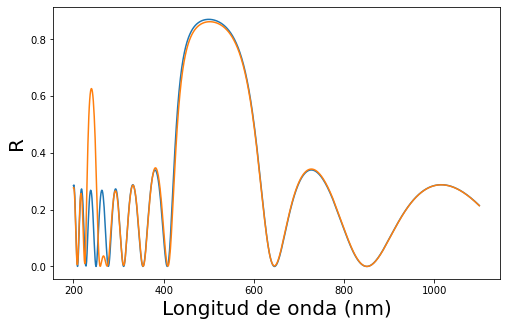

139 17.939620773087444
[60.37368357890699, 80.35101288057895, 67.05708578788526, 70.43522408162391, 69.61566995258949, 68.41419259317827, 67.90349340420396, 71.55688586177556, 65.94437097145817, 80.78994582190914]


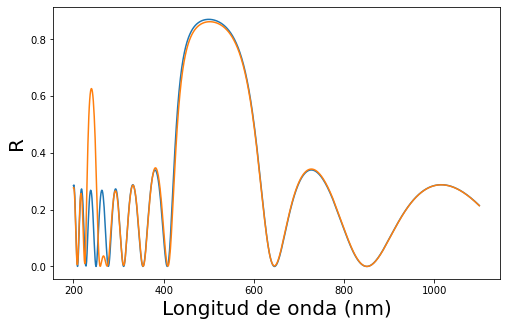

140 15.114088137506727
[57.810318940167235, 88.3415815142914, 61.28318780538811, 76.12663998787627, 63.32368706720427, 79.4617511066508, 64.08676401074345, 73.76176105499363, 61.780729288648175, 79.92908602807279]


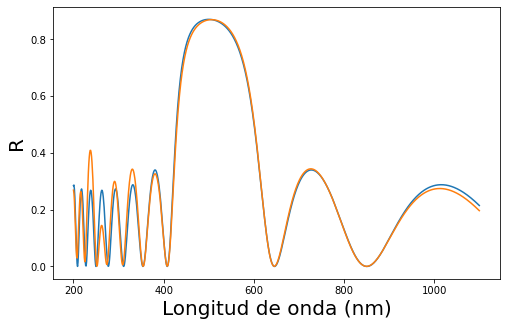

141 15.114088137506727
[57.810318940167235, 88.3415815142914, 61.28318780538811, 76.12663998787627, 63.32368706720427, 79.4617511066508, 64.08676401074345, 73.76176105499363, 61.780729288648175, 79.92908602807279]


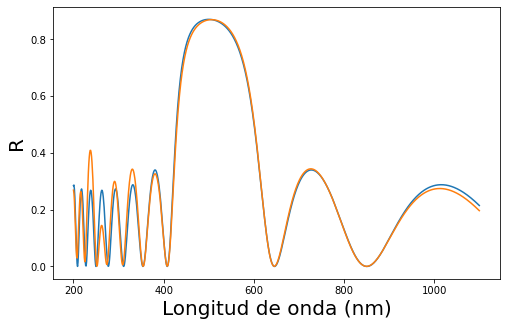

142 15.114088137506727
[57.810318940167235, 88.3415815142914, 61.28318780538811, 76.12663998787627, 63.32368706720427, 79.4617511066508, 64.08676401074345, 73.76176105499363, 61.780729288648175, 79.92908602807279]


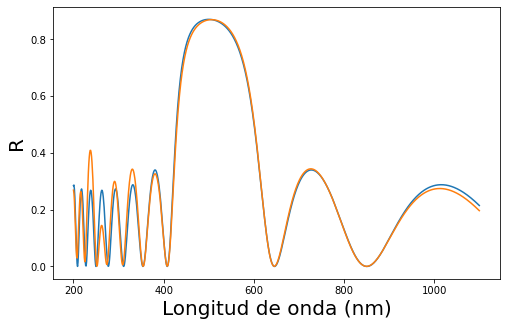

143 15.114088137506727
[57.810318940167235, 88.3415815142914, 61.28318780538811, 76.12663998787627, 63.32368706720427, 79.4617511066508, 64.08676401074345, 73.76176105499363, 61.780729288648175, 79.92908602807279]


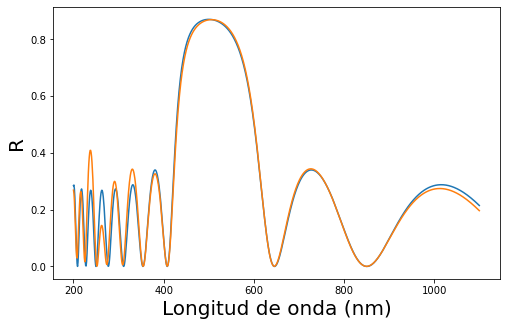

144 15.114088137506727
[57.810318940167235, 88.3415815142914, 61.28318780538811, 76.12663998787627, 63.32368706720427, 79.4617511066508, 64.08676401074345, 73.76176105499363, 61.780729288648175, 79.92908602807279]


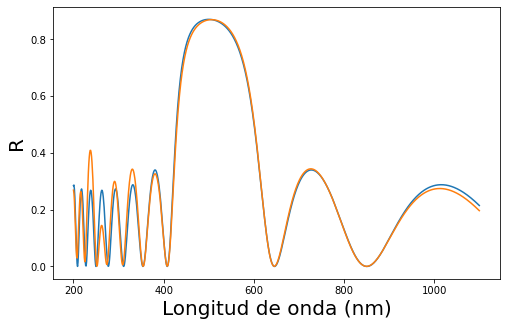

145 15.114088137506727
[57.810318940167235, 88.3415815142914, 61.28318780538811, 76.12663998787627, 63.32368706720427, 79.4617511066508, 64.08676401074345, 73.76176105499363, 61.780729288648175, 79.92908602807279]


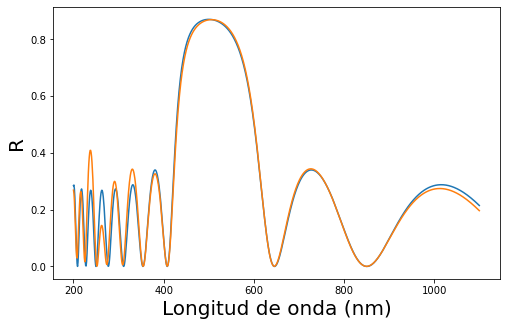

146 15.114088137506727
[57.810318940167235, 88.3415815142914, 61.28318780538811, 76.12663998787627, 63.32368706720427, 79.4617511066508, 64.08676401074345, 73.76176105499363, 61.780729288648175, 79.92908602807279]


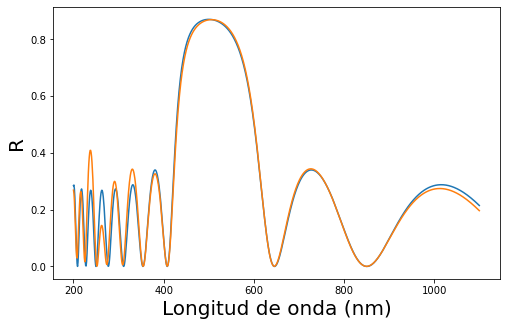

147 14.12713971104084
[57.39368529424511, 86.90797424095283, 61.65725239966918, 77.18746497349127, 63.130268797286284, 80.16734172931221, 63.04287798990445, 73.69531987306713, 62.631686661778645, 80.41028494965934]


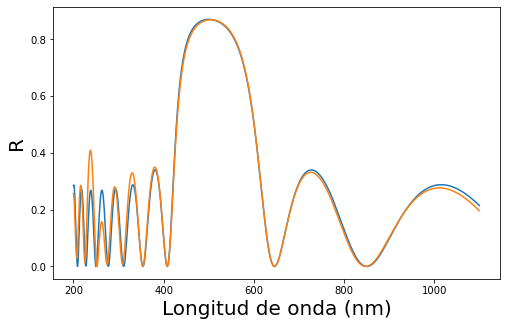

148 14.12713971104084
[57.39368529424511, 86.90797424095283, 61.65725239966918, 77.18746497349127, 63.130268797286284, 80.16734172931221, 63.04287798990445, 73.69531987306713, 62.631686661778645, 80.41028494965934]


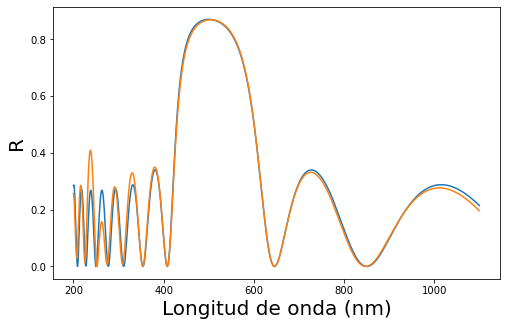

149 14.12713971104084
[57.39368529424511, 86.90797424095283, 61.65725239966918, 77.18746497349127, 63.130268797286284, 80.16734172931221, 63.04287798990445, 73.69531987306713, 62.631686661778645, 80.41028494965934]


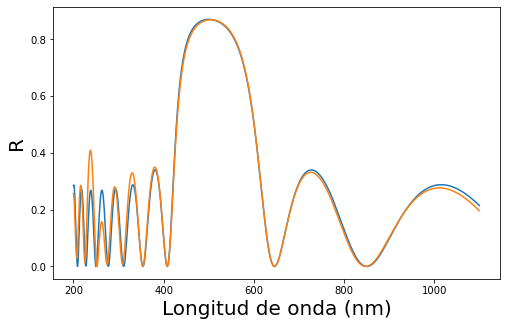

150 14.12713971104084
[57.39368529424511, 86.90797424095283, 61.65725239966918, 77.18746497349127, 63.130268797286284, 80.16734172931221, 63.04287798990445, 73.69531987306713, 62.631686661778645, 80.41028494965934]


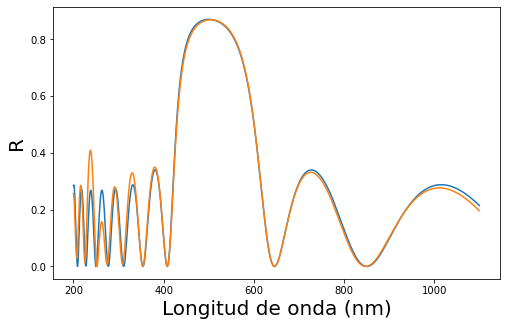

In [10]:
ErrorMin, Dmin= Gen(ro, lo, mat1, mat2, M, values[0], values[1], espesor1=10, espesor2=100)
#Gen(ro, l, mat1, mat2, M, pob=5, S=10, err0=10)

In [11]:
#calculamos la reflectancia del padre mejor adaptado
R, D = PC(M, mat1, mat2, lo,Dmin)

In [12]:
#guardamos los valores de longitud de onda y reflectancia en un txt
file = open("2.1_1.5_R.txt", "a+")
for i in range(len(R)):
    file.write(str(lo[i]) + " " + str(R[i]) + "\n")
file.close()
#guardamos los valores de espesores del padre mejor adapatado en un txt
file = open("2.1_1.5_D.txt", "a+")
file.write(str(D))
file.close()

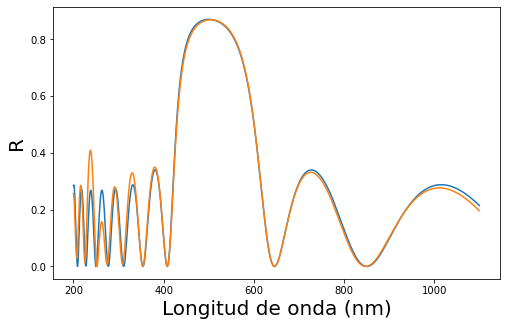

In [13]:
#Graficamos el valor obtenido y el deseado
#r3, d3 = PC(M, mat1, mat2,lo, Dmin)
plt.figure(figsize=(8,5))
plt.plot(lo,ro)
plt.plot(lo,R)

plt.xlabel("Longitud de onda (nm)", fontsize=20)
plt.ylabel("R", fontsize = 20)
#plt.ylim(0.,1.)
plt.show()

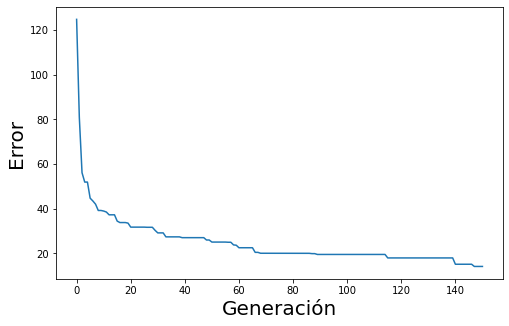

In [14]:
#graficamos el error en cada generación
plt.figure(figsize=(8,5))
plt.plot(ErrorMin)

plt.xlabel("Generación", fontsize=20)
plt.ylabel("Error", fontsize = 20)

plt.show()